# Heart Disease Classification

**Table of contents:**
- [Introduction](#intro)
- [Reading in dataset](#readin)
- [Data structure (Univariate Analysis)](#data_structure)
    - [Histograms](#histograms")
    - [Box plots metric variables](#box_plots)
    - [Insights of the univariate analysis](#insights_univ)
- [Splitting data into training and test set](#split)


- [Exploratory Data Analysis (Bivariate Analysis)](#eda)
    - [Relationship between predictors and outcome](#pred_outcome)
        - [Categorical predictors and outcome](#cat_pred_outcome)
            - Proportions plot
            - Chi-Squared tests
        - [Numeric predictors and outcome](#num_pred_outcome)
            - Box plots, Proportions plot
            - Test statistic for metric independent variables (Shapiro-Wilk for normal distribution, subsequently Mann-Whitney-U for group comparison)
    - [Relationship between predictors](#pred_pred)
        - Chi-squared test among categorical predictors
        - Correlations between metric predictors
        - Relationship between metric and categorical predictors
    - [further possible questions](#further_q)
        - 1. Are women with myocardial infarction more frequently asymptomatic than men?
        - 2. Do elevated blood pressure, blood sugar and cholesterol occur together more often?

    
- [Preprocessing](#preprocessing)
    - [Data Cleaning](#clean)
        - Missing values
        - Inconsistent values
    - [Data Transformation](#transform)
        - Scaling
        - Encoding of remaining categorical variables


- [Model Training](#training)
- [Model Evaluation](#eval)
    - Data preprocessing for test set
    - [Evaluation on the test set and metrics](#eval_test)


- [Limitations](#limitations)
- [Conclusion](#conclusion)++++++++++++++++++++++++++++++++++++++++++
- [Bibliography](#bibliography)

In [273]:
# !pip install missingno
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import missingno
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import chi2, chi2_contingency, mannwhitneyu, pearsonr, shapiro
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import statsmodels.stats.proportion as smp

## Introduction<a name="intro"></a>

Coronary heart disease is a chronic disease of the heart with a narrowing of the coronary arteries. This can lead to disturbed blood flow of the heart muscle. Complications such as a myocardial infarction, heart insufficiency and cardiac arrythmias are possible consequences.
Coronary heart disease is the leading common cause of death in Germany and around the world and leads to high costs in the health system (Busch, Kuhnert 2017).
Several risk factors such as smoking, high blood pressure, diabetes and high cholesterol levels, among others, play a role in causing the disease.
It can be diagnosed by means of invasive and non-invasive techniques. 

The aim of the project is to predict the occurence of coronary heart disease in patients.

The dataset originates from the  UCI Machine Learning Repository: Heart Disease Data Set, July 1988 (http://archive.ics.uci.edu/ml/datasets/Heart+Disease).
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D. 

**Possible use case:**

A possible use case would be screening for and identifying high-risk patients.

The target audience who the project is aimed for could be general practioners and cardiologists.
They would need to perform cardiac examinations and the results would be fed into the algorithm.  
A first screening could be performed on cheaper parameters, such as age, cholesterol levels, blood pressure, blood sugar and a resting ECG in order to avoid examinations in healthy patients with low risk.
If the patient is screened / classified positive by the algorithm for heart disease, the following consequences could be drawn in an attempt to reduce risk of complications such as a myocardial infarction: prescribing or changing medication, regular check-ups, reducing risk factors or peforming coronary angiography with possible stent implantation.

Apart from the ethical perspective of preventing or reducing the risk of disease, this use case could also be of interest for health insurance companies regarding cost-effectiveness:
Would it be more cost-efficient to pay extra cardiac examinations for screening than paying for rehabilitation and disability if the screening is not performed?

If an accurate classifier could be used, this could benefit patients (personal health), doctors (aid in better diagnosis, more targeted care), possibly health insurance companies (reducing hospital/rehabilitation/disability costs) and the country in general(improved health of population).

## Reading in dataset<a name="readin"></a>

Variables in the dataset
- __age__: age in years
- __sex__: sex (1 = male; 0 = female)
- __cp: chest pain type__
    -  1: typical angina 
    -  2: atypical angina 
    -  3: non-anginal pain 
    -  4: asymptomatic
- __trestbps: resting blood pressure__ (in mm Hg on admission to the hospital)
- __chol: serum cholestoral__ in mg/dl
- __fbs: (fasting blood sugar__ > 120 mg/dl)  (1 = true; 0 = false)
- __restecg__: resting electrocardiographic results
     -  0: normal
     -  1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
     -  2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- __thalach__: maximum heart rate achieved
- __exang__: exercise induced angina (1 = yes; 0 = no)
- __oldpeak__ = ST depression induced by exercise relative to rest
- __slope__: the slope of the peak exercise ST segment - Value 1: upsloping - Value 2: flat - Value 3: downsloping
- __ca__: number of major vessels (0-3) colored by flourosopy
- __thal__: 3 = normal; 6 = fixed defect; 7 = reversable defect

target variable:<br>
__num__: diagnosis of heart disease (angiographic disease status)

In [274]:
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

#### Reading in separate databases

In [275]:
processed_cleveland = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                                  names=column_names, 
                                  na_values="?")
processed_cleveland.shape

(303, 14)

In [276]:
processed_hungarian = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", 
                                  names=column_names, 
                                  na_values="?")
processed_hungarian.shape

(294, 14)

In [277]:
processed_switzerland = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", 
                                    names=column_names, 
                                    na_values="?")
processed_switzerland.shape

(123, 14)

In [278]:
processed_long_beach = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", 
                                   names=column_names, 
                                   na_values="?")
processed_long_beach.shape

(200, 14)

#### Concatenate tables into one

In [279]:
total_data = pd.concat([processed_cleveland, processed_hungarian, processed_switzerland, processed_long_beach])
total_data.shape

(920, 14)

## Data structure (Univariate Analysis)<a name="data_structure"></a>

In [280]:
total_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [281]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 0 to 199
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float64
 1   sex       920 non-null    float64
 2   cp        920 non-null    float64
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    float64
 6   restecg   918 non-null    float64
 7   thalach   865 non-null    float64
 8   exang     865 non-null    float64
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    float64
 11  ca        309 non-null    float64
 12  thal      434 non-null    float64
 13  num       920 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 107.8 KB


In [282]:
total_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,920.000000,920.000000,920.000000,861.000000,890.000000,830.000000,918.000000,865.000000,865.000000,858.000000,611.000000,309.000000,434.000000,920.000000
mean,53.510870,0.789130,3.250000,132.132404,199.130337,0.166265,0.604575,137.545665,0.389595,0.878788,1.770867,0.676375,5.087558,0.995652
std,9.424685,0.408148,0.930969,19.066070,110.780810,0.372543,0.805827,25.926276,0.487941,1.091226,0.619256,0.935653,1.919075,1.142693
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,175.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,0.000000,6.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,268.000000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


* mean age: 54 years
* 79% male, 21% female
* 17% with elevated blood sugar / diabetes

#### Value counts for categorical data:

In [283]:
# sex (1 = male; 0 = female)

total_data['sex'].value_counts(dropna=False)

1.0    726
0.0    194
Name: sex, dtype: int64

In [284]:
# cp: chest pain type
# - Value 1: typical angina 
# - Value 2: atypical angina 
# - Value 3: non-anginal pain 
# - Value 4: asymptomatic

total_data['cp'].value_counts(dropna=False)

4.0    496
3.0    204
2.0    174
1.0     46
Name: cp, dtype: int64

In [285]:
# restecg: resting electrocardiographic results
# - Value 0: normal
# - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
# - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

total_data['restecg'].value_counts(dropna=False)

0.0    551
2.0    188
1.0    179
NaN      2
Name: restecg, dtype: int64

In [286]:
# exang: exercise induced angina (1 = yes; 0 = no)

total_data['exang'].value_counts(dropna=False)

0.0    528
1.0    337
NaN     55
Name: exang, dtype: int64

In [287]:
# slope: the slope of the peak exercise ST segment
#    Value 1: upsloping
#    Value 2: flat
#    Value 3: downsloping

total_data['slope'].value_counts(dropna=False)

2.0    345
NaN    309
1.0    203
3.0     63
Name: slope, dtype: int64

In [288]:
# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

total_data['thal'].value_counts(dropna=False)

NaN    486
3.0    196
7.0    192
6.0     46
Name: thal, dtype: int64

In [289]:
# num: diagnosis of heart disease
# no heart disease (value of 0) or various degrees of heart disease (values 1 to 4). 

total_data['num'].value_counts(dropna=False)

0    411
1    265
2    109
3    107
4     28
Name: num, dtype: int64

#### Further analysis of the variable 'thal' (frequency of attributes):

In [290]:
# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

total_data['thal'].value_counts(dropna=False)

NaN    486
3.0    196
7.0    192
6.0     46
Name: thal, dtype: int64

In [291]:
print("Percentage of thal in total sample: ")
total_data.thal[(total_data.thal == 7)|(total_data.thal == 6)].count()*100/len(total_data)

Percentage of thal in total sample: 


25.869565217391305

In [292]:
processed_hungarian['thal'].value_counts(dropna=False)

NaN    266
7.0     11
6.0     10
3.0      7
Name: thal, dtype: int64

In [293]:
print("Percentage of thal in hungarian sample: ")
processed_hungarian.thal[(processed_hungarian.thal == 7)|(processed_hungarian.thal == 6)].count()*100/len(processed_hungarian)

Percentage of thal in hungarian sample: 


7.142857142857143

In [294]:
processed_switzerland['thal'].value_counts(dropna=False)

NaN    52
7.0    42
3.0    19
6.0    10
Name: thal, dtype: int64

In [295]:
print("Percentage of thal in Swiss sample: ")
processed_switzerland.thal[(processed_switzerland.thal == 7)|(processed_switzerland.thal == 6)].count()*100/len(processed_switzerland)

Percentage of thal in Swiss sample: 


42.27642276422764

In [296]:
processed_cleveland['thal'].value_counts(dropna=False)

3.0    166
7.0    117
6.0     18
NaN      2
Name: thal, dtype: int64

In [297]:
print("Percentage of thal in Cleveland, US, sample: ")
processed_cleveland.thal[(processed_cleveland.thal == 7)|(processed_cleveland.thal == 6)].count()*100/len(processed_cleveland)

Percentage of thal in Cleveland, US, sample: 


44.554455445544555

In [298]:
processed_long_beach['thal'].value_counts(dropna=False)

NaN    166
7.0     22
6.0      8
3.0      4
Name: thal, dtype: int64

In [299]:
print("Percentage of thal in Long Beach, US, sample: ")
processed_long_beach.thal[(processed_long_beach.thal == 7)|(processed_long_beach.thal == 6)].count()*100/len(processed_long_beach)

Percentage of thal in Long Beach, US, sample: 


15.0

#### Histograms<a name="histograms"></a>

In [300]:
colors = ["silver", "dimgrey"]
sns.set_palette(sns.color_palette(colors))

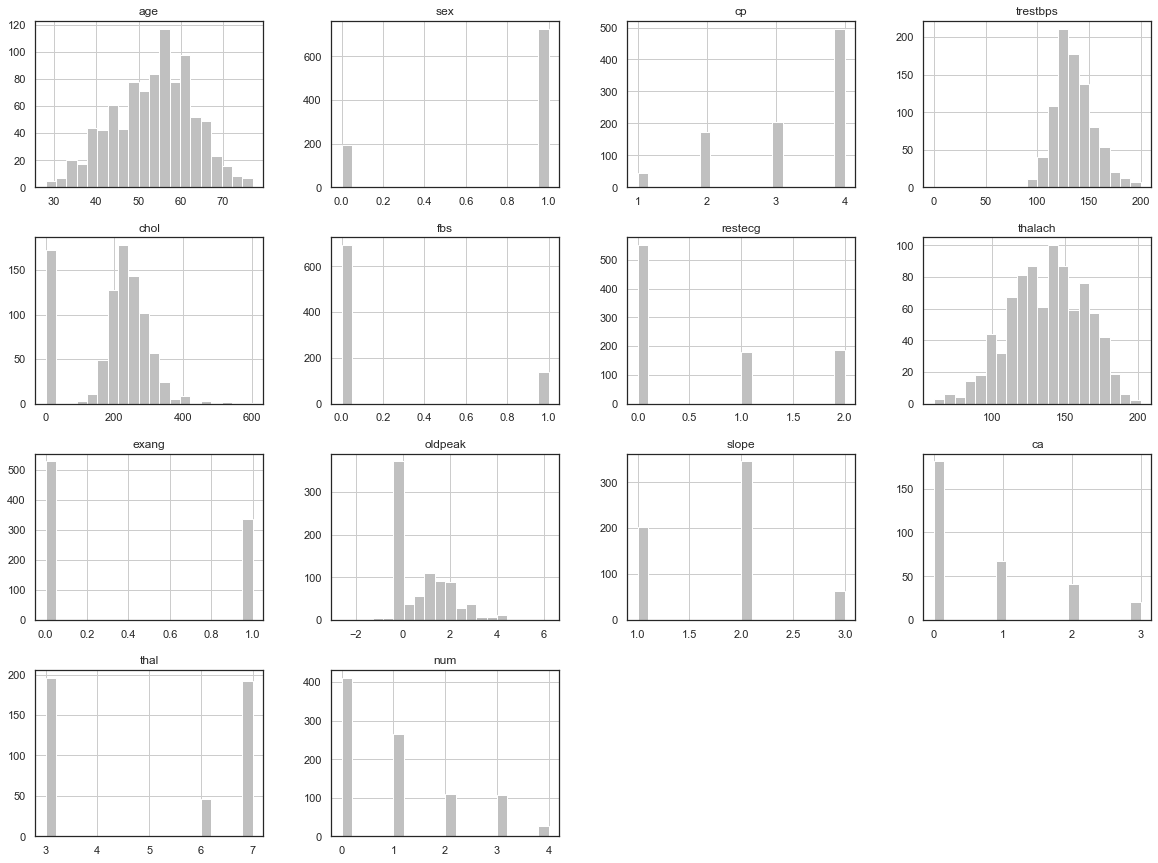

In [301]:
total_data.hist(bins=20, figsize=(20,15))
plt.show()

#### Box plots for metric variables<a name="box_plots"></a>

Box plots give an overview of the variable's distribution and its symmetry. However, it does not show if the distribution has multiple peaks (Kuhn, Johnson 2019). Hence, the histograms for each variable are added on the same scale in the plot.

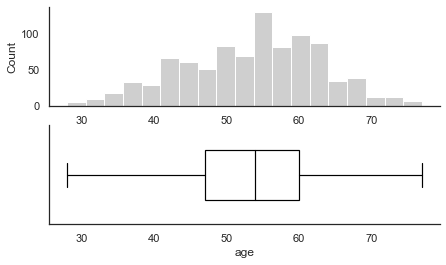

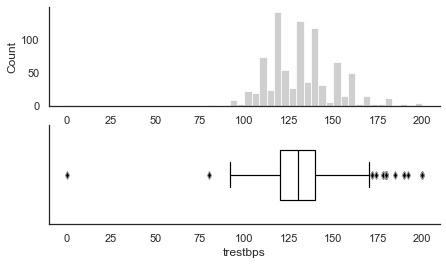

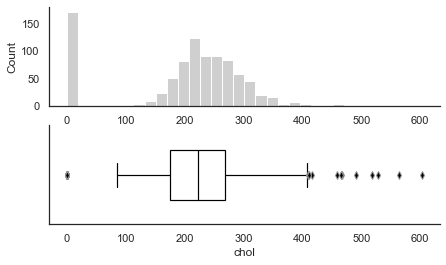

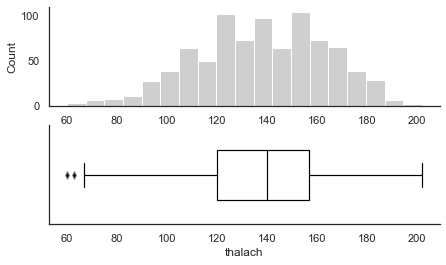

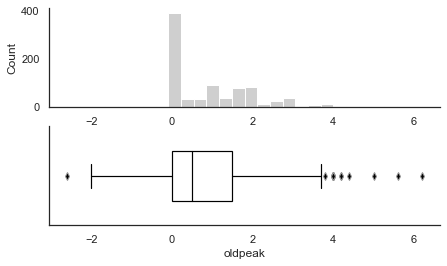

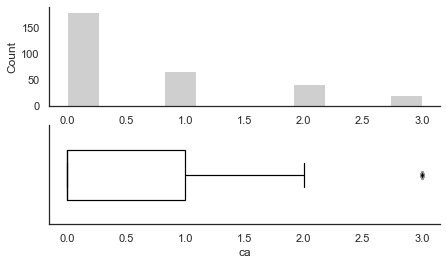

In [302]:
metric_vars = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'markerfacecolor':'black'}
}

for var in metric_vars:
    sns.set_palette(sns.color_palette(colors))
    f, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,4))
    sns.histplot(x=total_data[var], ax=axes[0])
    sns.set(style="white")
    sns.boxplot(x=total_data[var], color='white', width=0.5, linewidth=1.2, **PROPS, ax=axes[1])
    sns.despine()

#### Insights of the univariate analysis<a name="insights_univ"></a>

- data types: mostly float, except for target variable (int) -> feature variables need to be converted from float to integer/categorical
- null values are present in 10 variables, they have to be imputed or affected rows or variables deleted
- false values have to be removed or imputed (e.g. resting blood pressure of 0 mmHg as mininmal value, many values of 0 for cholesterol)


- it is unclear what units the variable 'oldpeak' (ST depression induced by exercise relative to rest) uses.


- there are more males in the dataset than females (726 vs. 194)
- there are few people with a typical angina pectoris symptomatology (46 vs. 496+204+174)
- the majority of people in the sample have a normal ecg (551 vs. 188+179)
- there are few patients with a fasting blood sugar > 120 mg/dl in the sample (= there are few patients with diabetes in the sample)
- target variable 'num': there is no information as to what the various degrees of heart disease (values 1 to 4) mean --> need for conversion to binary variable (heart disease yes/no)
- a comparison of statistics between the two groups (with / without heart disease) may show further insights

It is unclear what the variable 'thal' represents. There is no information provided in the original data source. 

Some sources suspect it to concern the disease thalassemia (Pereira 2020, Porto et al. 2021, Rasool et al. 2020), a genetic disorder of hemoglobin synthesis. Thalassemia mainly occurs in South East Asia, India, the Middle East and Africa (Amboss 2021). It is described that hemoglobinopathies, which are the superordinate class under which thalassemia can be categorized, also occur in other countries such as the Mediterranean (Betke 1980). The US is also listed with a prevalence of 5-20% of genetic carriers of hemoglobinopathies (Kohne 2011). 

The data was collected at four hospitals in Hungary, Switzerland and in the US (2 hospitals). Comparing the prevalence of 'thal' in the four samples with the prevalence of hemoglobinopathies shows that it is improbable that this variable really represents thalassemia. The prevalence in the four samples (with 7%, 42%, 44% and 15% respectively) is a lot higher than can be expected for hemoglobinopathies. In addition, the feature characteristics 'fixed defect' and 'reversable defect' do not apply, as thalassemia is a genetic disease.

Other sources assume that the 'thal' variable describes exercise thallium scintigraphy (Gárate-Escamila et al. 2020).

### Transforming target variable and renaming columns

In [303]:
# num: no heart disease (value of 0) or various degrees of heart disease (values 1 to 4). 
# --> group  data into 2 categories of ‘no heart disease’ (0) and ‘ heart disease’ (1).
total_data['heart_disease'] = np.where(total_data['num'] > 0, 1, 0)
total_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,heart_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,54.0,0.0,4.0,127.0,333.0,1.0,1.0,154.0,0.0,0.0,NaN,NaN,NaN,1,1
196,62.0,1.0,1.0,NaN,139.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
197,55.0,1.0,4.0,122.0,223.0,1.0,1.0,100.0,0.0,0.0,NaN,NaN,6.0,2,1
198,58.0,1.0,4.0,NaN,385.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [304]:
total_data = total_data.rename({'cp': 'chest_pain', 
                               'trestbps': 'blood_press',
                               'fbs': 'blood_sugar',
                               'thalach': 'max_heart_rate',
                               'exang': 'exercise_angina',
                               'oldpeak': 'ST_depression',
                               'slope': 'slope_ST',
                               'ca': 'vessels_fluor'},
                               axis='columns')

In [305]:
total_data

,age,sex,chest_pain,blood_press,chol,blood_sugar,restecg,max_heart_rate,exercise_angina,ST_depression,slope_ST,vessels_fluor,thal,num,heart_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,54.0,0.0,4.0,127.0,333.0,1.0,1.0,154.0,0.0,0.0,NaN,NaN,NaN,1,1
196,62.0,1.0,1.0,NaN,139.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
197,55.0,1.0,4.0,122.0,223.0,1.0,1.0,100.0,0.0,0.0,NaN,NaN,6.0,2,1
198,58.0,1.0,4.0,NaN,385.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0


## Splitting data into training and test set<a name="split"></a>

In order to prevent sampling bias and to ensure that the test set is representative of the whole data set with regards to the target attribute, a stratified sample is used. The test set is set to be 20% of the data.

In [306]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(total_data, total_data['num']):
    strat_train_set = total_data.iloc[train_index]
    strat_test_set = total_data.iloc[test_index]

In [307]:
# comparing the distribution of the target attribute in the training and test set
train_test_distribution_num = (strat_train_set['num'].value_counts()/len(strat_train_set)*100).to_frame(name='strat_train_set[num]_percent')
train_test_distribution_num['strat_test_set[num]_percent'] = strat_test_set['num'].value_counts()/len(strat_test_set)*100
train_test_distribution_num

,strat_train_set[num]_percent,strat_test_set[num]_percent
0,44.701087,44.565217
1,28.804348,28.804348
2,11.820652,11.956522
3,11.684783,11.413043
4,2.989130,3.260870


In [308]:
# comparing mean and standard deviation of the training and test set
train_test_stats = strat_train_set.mean().to_frame(name='strat_train_set.mean')
train_test_stats['strat_test_set.mean'] = strat_test_set.mean()
train_test_stats['strat_train_set.std'] = strat_train_set.std()
train_test_stats['strat_test_set.std'] = strat_test_set.std()
train_test_stats

,strat_train_set.mean,strat_test_set.mean,strat_train_set.std,strat_test_set.std
age,53.315217,54.293478,9.427913,9.396591
sex,0.779891,0.826087,0.414602,0.380069
chest_pain,3.241848,3.282609,0.933832,0.921226
blood_press,131.815942,133.409357,19.272382,18.208489
chol,196.232722,210.480663,111.608316,107.023860
blood_sugar,0.159574,0.191860,0.366490,0.394914
restecg,0.598093,0.630435,0.804521,0.812705
max_heart_rate,137.731988,136.789474,25.971184,25.805200
exercise_angina,0.378963,0.432749,0.485479,0.496912
ST_depression,0.873071,0.901754,1.089769,1.099972


## Exploratory Data Analysis (Bivariate Analysis)<a name="eda"></a>

In [309]:
data = strat_train_set.copy()

# removing 'num' column from the dataframe
data = data.drop(['num'], axis=1)

In [310]:
data_labelled= data.copy()
data_labelled['sex'] = data['sex'].map({0: 'female', 1: 'male'})
data_labelled['chest_pain'] = data['chest_pain'].map({1: 'typical angina', 2: 'atypical angina', 3: 'non-anginal pain', 4: 'asymptomatic'})
data_labelled['blood_sugar'] = data['blood_sugar'].map({0: 'normal blood sugar', 1: 'blood sugar>120mg/dl'})
data_labelled['exercise_angina'] = data['exercise_angina'].map({0: 'no_exercise_angina', 1: 'exercise_induced_angina'})
data_labelled['restecg'] = data['restecg'].map({0: 'normal', 1: 'ST-T wave abnormality', 2: 'left ventricular hypertrophy'})
data_labelled['slope_ST'] = data['slope_ST'].map({1: 'upsloping', 2: 'flat', 3: 'downsloping'})
data_labelled['thal'] = data['thal'].map({3: 'normal', 6: 'fixed defect', 7: 'reversable defect'})

### Relationship between predictors and outcome<a name="pred_outcome"></a>

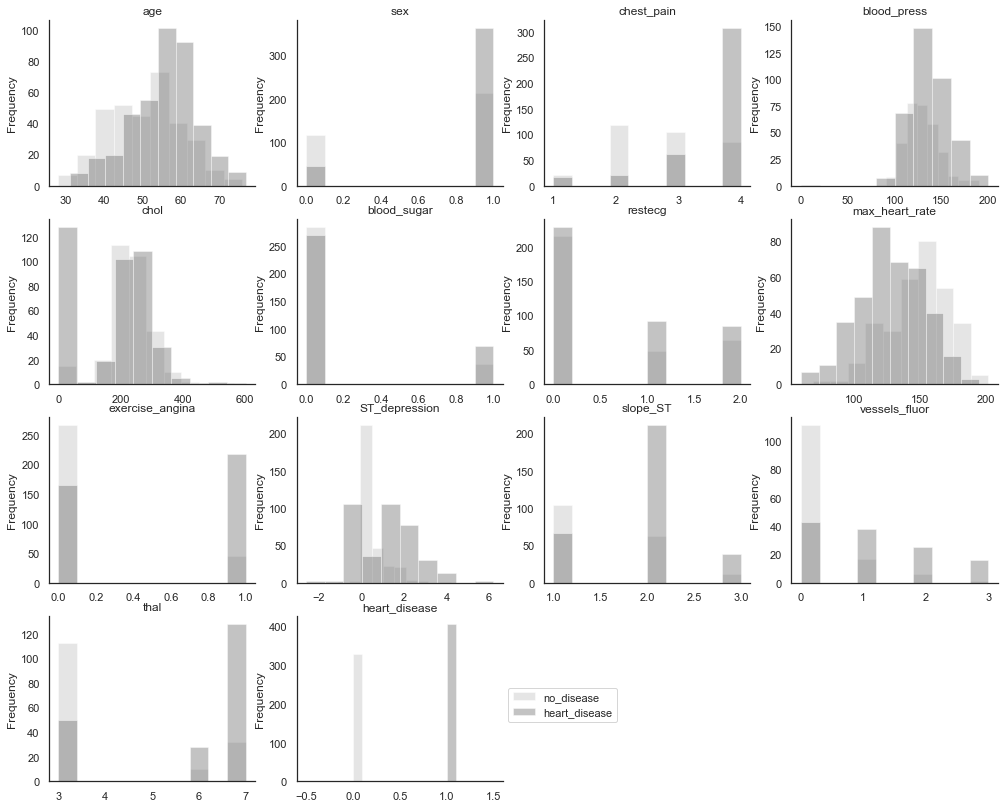

In [311]:
# comparing histograms for the groups heart disease vs. no disease
grouped = data.groupby('heart_disease')

colors = ["silver", "dimgrey"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(17, 14))
i=1
for (columnName, columnData) in data.iteritems():
        plt.subplot(4, 4, i)
        grouped[columnName].plot.hist(alpha=0.4)
        plt.title(columnName)
        sns.despine()
        i = i+1
plt.legend(["no_disease", "heart_disease"], bbox_to_anchor=(1, 0.6))
plt.show()

In [312]:
# percentage of heart_disease patients in the training set
hd_rate = (data['heart_disease']==1).mean()
print("Rate of heart disease among patients in train set: ", hd_rate)

Rate of heart disease among patients in train set:  0.5529891304347826


In [313]:
categorical_vars = ['sex', 'chest_pain', 'blood_sugar', 'restecg', 'exercise_angina', 'slope_ST', 'thal']

In [314]:
metric_vars = list(set(data.columns) - set(categorical_vars))
metric_vars.remove('heart_disease')
metric_vars

['vessels_fluor',
 'chol',
 'age',
 'blood_press',
 'max_heart_rate',
 'ST_depression']

#### Categorical predictors and outcome<a name="cat_pred_outcome"></a>

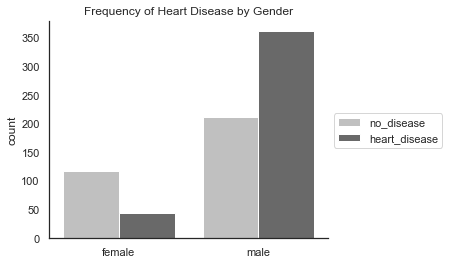

In [315]:
# Histogram Heart Disease by Gender
plt.figure(figsize=(5,4))
sns.countplot(x="sex", hue="heart_disease", data=data).set_xticklabels(['female', 'male'])
plt.title("Frequency of Heart Disease by Gender")
plt.xlabel("")
plt.legend(["no_disease", "heart_disease"], bbox_to_anchor=(1, 0.6))
sns.despine()
plt.show()

It is visible that there were fewer women than men in the sample. The occurence of heart disease can be seen for both gender groups.

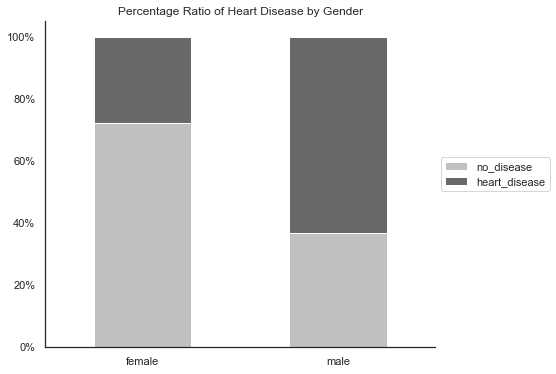

In [316]:
# percentage plot of heart disease by gender
ax=data.groupby(['sex','heart_disease']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True, figsize=(7, 6))
ax.set_xticklabels(['female', 'male'],  rotation = 0)
ax.set_xlabel("")
ax.set_title("Percentage Ratio of Heart Disease by Gender")
plt.legend(["no_disease", "heart_disease"], bbox_to_anchor=(1, 0.6))
sns.despine()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

This plot does not illustrate how many men or women have heart disease, but focuses on the ratio of disease within females and within males. As Kuhn and Johnson (2019) suggest, a display of the proportion of heart disease with a 95% confidence interval may be most suitable. Hence, this form of presentation will be used in the following, as it shows the magnitude and uncertainty. The baseline rate of heart disease (0.55) is shown as a red dashed line for referral.

In [317]:
def calculate_proportions_ci(var):
    proportions = []
    for i in data[var].dropna().unique(): # nan-values are excluded for the calculation

        positives = data.groupby([var, 'heart_disease']).size()[i,1]
        patients = data.groupby([var]).size()[i]
        proportion = positives/patients
        
        ci_low, ci_upp = smp.proportion_confint(positives, patients, alpha=0.05, method='normal')
        proportions.append([i, proportion, ci_low, ci_upp])

    proportions_df = pd.DataFrame(proportions, columns=['value', 'proportion', 'ci_low', 'ci_upp'])
    return proportions_df

In [318]:
def plot_proportions_ci(var, xticks, xticklabels, title):
    yerr = [np.subtract(calculate_proportions_ci(var).proportion, calculate_proportions_ci(var).ci_low), np.subtract(calculate_proportions_ci(var).ci_upp, calculate_proportions_ci(var).proportion)]
    plt.errorbar(calculate_proportions_ci(var).value, calculate_proportions_ci(var).proportion, fmt='o', yerr=yerr, color='black', capsize=2)
    plt.xticks(xticks, xticklabels, rotation = 0)
    plt.title("Heart Disease across "+title)
    plt.ylabel("Proportion")
    plt.axhline(y=hd_rate, color='r', linestyle='dashed')
    plt.show()

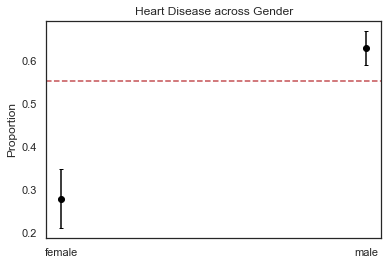

In [319]:
plot_proportions_ci('sex', [0,1], ['female', 'male'], 'Gender')

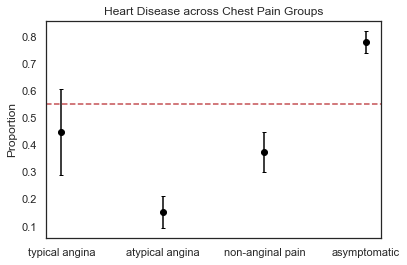

In [320]:
plot_proportions_ci('chest_pain', [1,2,3,4], ["typical angina", "atypical angina", "non-anginal pain", "asymptomatic"], 'Chest Pain Groups')

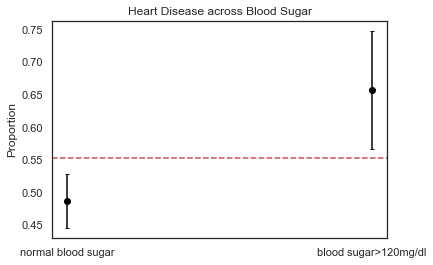

In [321]:
# nan-values excluded for the calculation
plot_proportions_ci('blood_sugar', [0,1], ["normal blood sugar", "blood sugar>120mg/dl"], 'Blood Sugar')

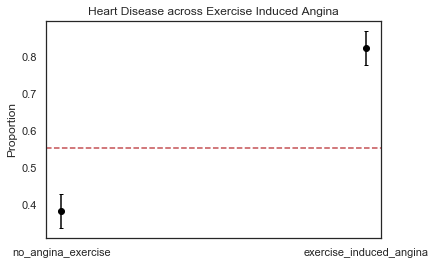

In [322]:
# nan-values excluded for the calculation
plot_proportions_ci('exercise_angina', [0,1], ["no_angina_exercise", "exercise_induced_angina"], 'Exercise Induced Angina')

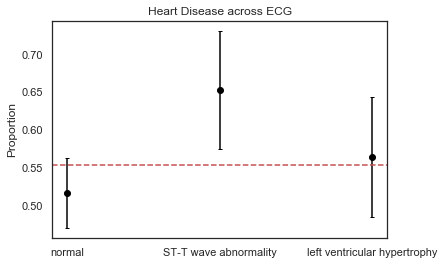

In [323]:
# nan-values excluded for the calculation
plot_proportions_ci('restecg', [0,1,2], ["normal", "ST-T wave abnormality", "left ventricular hypertrophy"], 'ECG')

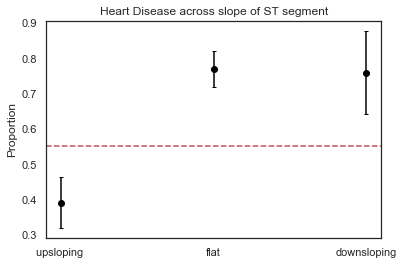

In [324]:
# nan-values excluded for the calculation
plot_proportions_ci('slope_ST', [1,2,3], ["upsloping ", "flat", "downsloping"], 'slope of ST segment')

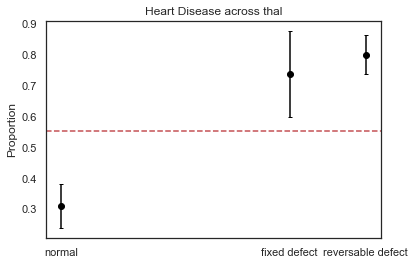

In [325]:
# nan-values excluded for the calculation
plot_proportions_ci('thal', [3,6,7], ['normal', 'fixed defect', 'reversable defect'], 'thal')

##### Chi-squared test for categorical variables

The Chi-Squared test of independence is used to check if two or more categorical variables are dependent on each other. The prerequisites for the test (nominal scale, independece of measurements and at least 5 observations for each cell) are all met for the following analyses with one exception (Hemmerich 2021a):
<br>(exception: heart_disease = 0 and vessels_fluor = 3.0 only has 1 patient)

In [326]:
# Chi Squared test for categorical variables
# modified from (Brownlee 2018b)

chi_statistics = pd.DataFrame(columns = ['feature_1', 'feature_2', 'chi2', 'p-value', 'dependent'])

for i in categorical_vars:
    contigency = pd.crosstab(data['heart_disease'], data[i])
    chi2_stat, p, dof, expected = chi2_contingency(contigency)
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    alpha = 1.0 - prob
    if p <= alpha:
        dep= True
    else:
        dep= False
    chi_statistics.loc[len(chi_statistics)] = ['heart_disease', i, chi2_stat.round(3), p.round(3), dep]

In [327]:
chi_statistics.sort_values(by=['chi2'], ascending=False)

,feature_1,feature_2,chi2,p-value,dependent
1,heart_disease,chest_pain,196.961,0.000,True
4,heart_disease,exercise_angina,127.323,0.000,True
6,heart_disease,thal,84.098,0.000,True
5,heart_disease,slope_ST,68.822,0.000,True
0,heart_disease,sex,62.228,0.000,True
2,heart_disease,blood_sugar,9.622,0.002,True
3,heart_disease,restecg,8.196,0.017,True


The tests showed that the categorical independent variables are related to the independent variable heart disease and should therefore be considered for inclusion in the model later on.
However, the Chi-Squared test only informs that there are differences between observed and expected values. It does not provide information on the direction or the strength of the effect (Hemmerich 2020).
Nevertheless, it is suggested that feature selection can be performed by choosing the variables with the highest chi2 values. Those could be regarded as the most relevant features (Brownlee 2019).

#### Numeric predictors and outcome<a name="num_pred_outcome"></a>

In [328]:
def calculate_proportions_metric(var):
    proportions = []
    for unit, count in data[var].value_counts().sort_index().iteritems(): 

            try:
                positives = data.groupby([var, 'heart_disease']).size()[unit,1]
            except KeyError:
                positives = 0
            patients = data.groupby([var]).size()[unit]
            proportion = positives/patients
            proportions.append([unit, proportion])
    proportions_df = pd.DataFrame(proportions, columns=['unit', 'proportion_hd'])
    return proportions_df

In [329]:
def plot_proportions_metric(var, xlabel, title):
    sns.lineplot(x=calculate_proportions_metric(var).unit, y=calculate_proportions_metric(var).proportion_hd, color="black")
    plt.xlabel(xlabel)
    plt.title("Heart Disease Proportion across "+title)
    plt.ylabel("Proportion")
    plt.axhline(y=hd_rate, color='r', linestyle='dashed')
    plt.show()

In [330]:
def binned(var, low_bin, high_bin, steps):
    data.sort_values(var, inplace=True)
    data[var+'_cut']=pd.cut(data[var], bins=range(low_bin, high_bin, steps))
    return var+'_cut'

In [331]:
def calculate_proportions_binned(var):
    proportions = []
    for i in data[var].dropna().unique(): # nan-values are excluded for the calculation

        positives = data.groupby([var, 'heart_disease']).size()[i,1]
        patients = data.groupby([var]).size()[i]
        proportion = positives/patients
        proportions.append([i, proportion])

    proportions_df = pd.DataFrame(proportions, columns=['interval', 'proportion'])
    return proportions_df

In [332]:
def plot_proportions_binned(var, xlabel, title):
    sns.catplot(x=calculate_proportions_binned(var).interval, y=calculate_proportions_binned(var).proportion, data=calculate_proportions_binned(var), aspect=2, kind="point", color="black")
    plt.xlabel(xlabel)
    plt.title("Heart Disease Proportion across "+title+" (binned)")
    plt.ylabel("Proportion")
    plt.axhline(y=hd_rate, color='r', linestyle='dashed')
    plt.show()

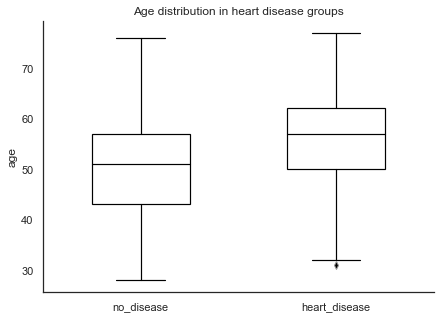

In [333]:
# boxplot age in heart disease groups
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'markerfacecolor':'black'}
}

plt.figure(figsize=(7,5))
sns.set(style="white")
sns.boxplot(x='heart_disease',y='age',data=data, color='white', width=0.5, linewidth=1.2, **PROPS).set_xticklabels(['no_disease', 'heart_disease'])
plt.title("Age distribution in heart disease groups")
plt.xlabel("")
sns.despine()

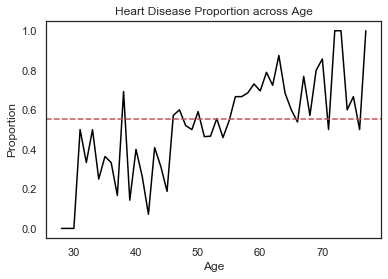

In [334]:
plot_proportions_metric('age', 'Age', 'Age')

Kuhn and Johnson (2019) suggest that a regression smoother such as loess may aid in representation of the probability across the values of the numeric predictor.

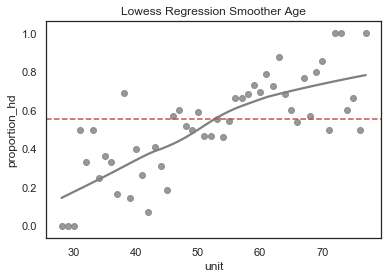

In [335]:
sns.regplot(x="unit", y="proportion_hd", data=calculate_proportions_metric('age'), lowess=True, color='grey').set_title("Lowess Regression Smoother Age")
plt.axhline(y=hd_rate, color='r', linestyle='dashed')
plt.show()

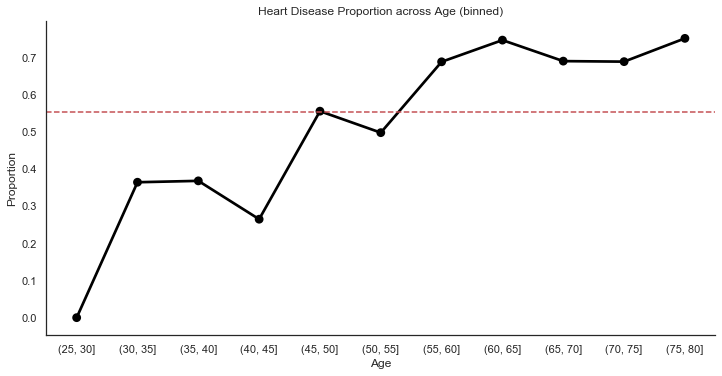

In [336]:
plot_proportions_binned(binned('age', 20, 90, 5), 'Age', 'Age')

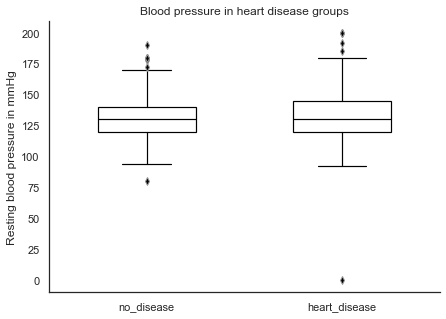

In [337]:
# Blood pressure in heart disease groups
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'markerfacecolor':'black'}
}

plt.figure(figsize=(7,5))
sns.set(style="white")
sns.boxplot(x='heart_disease',y='blood_press',data=data, color='white', width=0.5, linewidth=1.2, **PROPS).set_xticklabels(['no_disease', 'heart_disease'])
plt.title("Blood pressure in heart disease groups")
plt.xlabel("")
plt.ylabel("Resting blood pressure in mmHg")
#plt.ylim(data["blood_press"].min()-10, data["blood_press"].max()+10)
sns.despine()

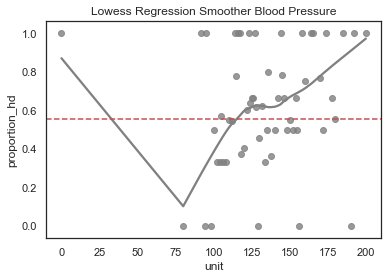

In [338]:
sns.regplot(x="unit", y="proportion_hd", data=calculate_proportions_metric('blood_press'), lowess=True, color='grey').set_title("Lowess Regression Smoother Blood Pressure")
plt.axhline(y=hd_rate, color='r', linestyle='dashed')
plt.show()

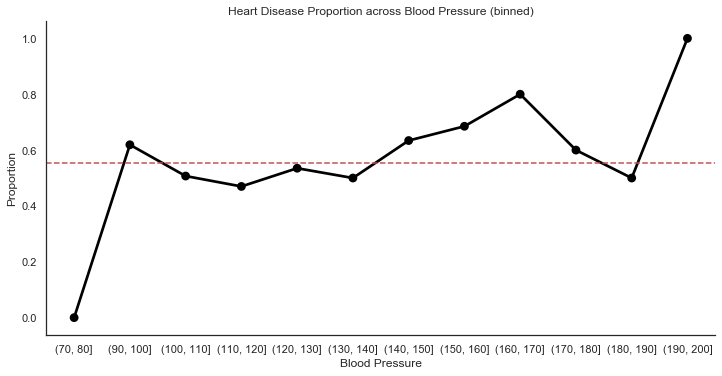

In [339]:
plot_proportions_binned(binned('blood_press', 50, 250, 10), 'Blood Pressure', 'Blood Pressure')

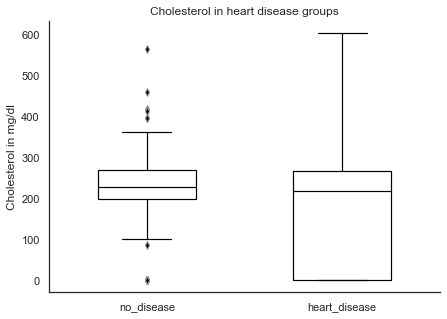

In [340]:
# boxplot cholesterol in heart disease groups
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'markerfacecolor':'black'}
}

plt.figure(figsize=(7,5))
sns.set(style="white")
sns.boxplot(x='heart_disease',y='chol',data=data, color='white', width=0.5, linewidth=1.2, **PROPS).set_xticklabels(['no_disease', 'heart_disease'])
plt.title("Cholesterol in heart disease groups")
plt.xlabel("")
plt.ylabel("Cholesterol in mg/dl")
sns.despine()

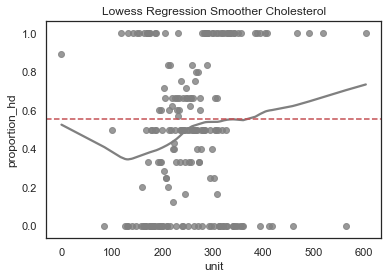

In [341]:
sns.regplot(x="unit", y="proportion_hd", data=calculate_proportions_metric('chol'), lowess=True, color='grey').set_title("Lowess Regression Smoother Cholesterol")
plt.axhline(y=hd_rate, color='r', linestyle='dashed')
plt.show()

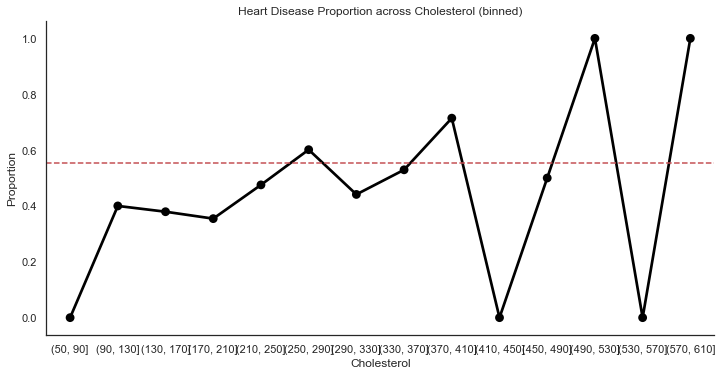

In [342]:
plot_proportions_binned(binned('chol', 50, 630, 40), 'Cholesterol', 'Cholesterol')

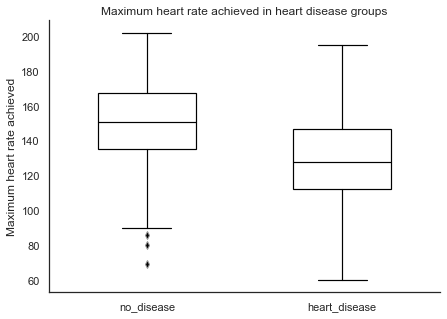

In [343]:
# boxplot maximum heart rate in heart disease groups
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'markerfacecolor':'black'}
}

plt.figure(figsize=(7,5))
sns.set(style="white")
sns.boxplot(x='heart_disease',y='max_heart_rate',data=data, color='white', width=0.5, linewidth=1.2, **PROPS).set_xticklabels(['no_disease', 'heart_disease'])
plt.title("Maximum heart rate achieved in heart disease groups")
plt.xlabel("")
plt.ylabel("Maximum heart rate achieved")
sns.despine()

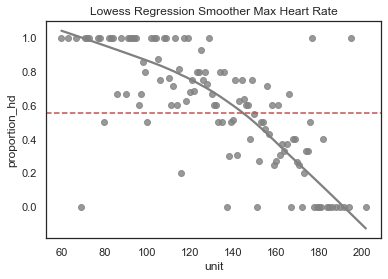

In [344]:
sns.regplot(x="unit", y="proportion_hd", data=calculate_proportions_metric('max_heart_rate'), lowess=True, color='grey').set_title("Lowess Regression Smoother Max Heart Rate")
plt.axhline(y=hd_rate, color='r', linestyle='dashed')
plt.show()

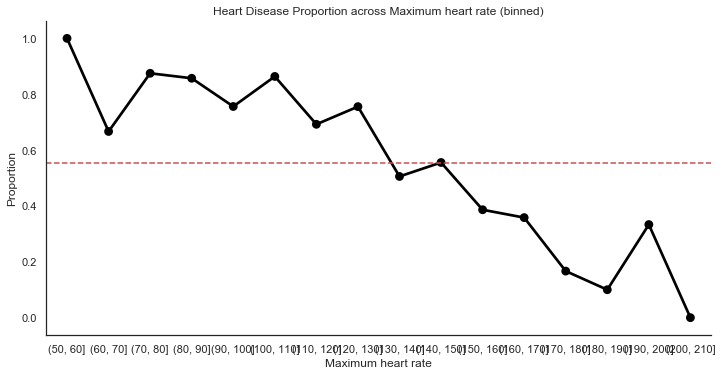

In [345]:
plot_proportions_binned(binned('max_heart_rate', 50, 250, 10), 'Maximum heart rate', 'Maximum heart rate')

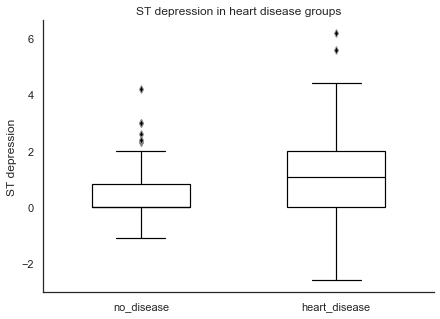

In [346]:
# boxplot ST depression in heart disease groups
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'markerfacecolor':'black'}
}

plt.figure(figsize=(7,5))
sns.set(style="white")
sns.boxplot(x='heart_disease',y='ST_depression',data=data, color='white', width=0.5, linewidth=1.2, **PROPS).set_xticklabels(['no_disease', 'heart_disease'])
plt.title("ST depression in heart disease groups")
plt.xlabel("")
plt.ylabel("ST depression")
sns.despine()

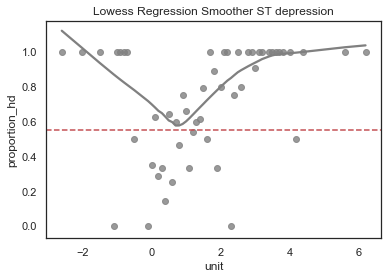

In [347]:
sns.regplot(x="unit", y="proportion_hd", data=calculate_proportions_metric('ST_depression'), lowess=True, color='grey').set_title("Lowess Regression Smoother ST depression")
plt.axhline(y=hd_rate, color='r', linestyle='dashed')
plt.show()

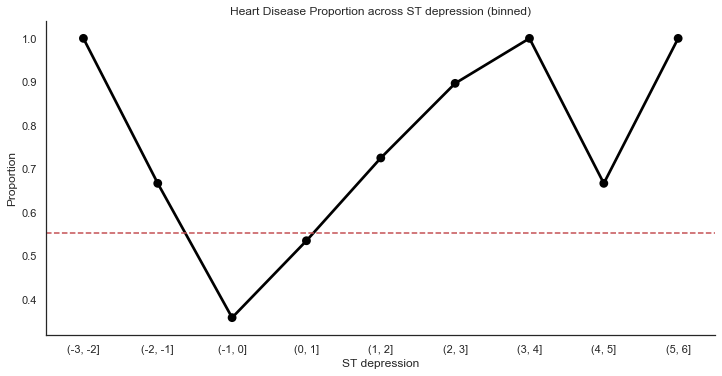

In [348]:
plot_proportions_binned(binned('ST_depression', -3, 7, 1), 'ST depression', 'ST depression')

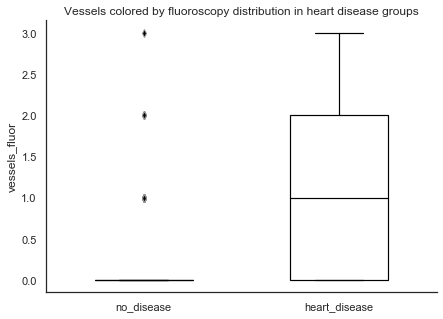

In [349]:
# boxplot vessels_fluor in heart disease groups
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'markerfacecolor':'black'}
}

plt.figure(figsize=(7,5))
sns.set(style="white")
sns.boxplot(x='heart_disease',y='vessels_fluor',data=data, color='white', width=0.5, linewidth=1.2, **PROPS).set_xticklabels(['no_disease', 'heart_disease'])
plt.title("Vessels colored by fluoroscopy distribution in heart disease groups")
plt.xlabel("")
sns.despine()

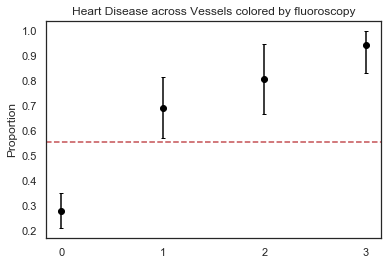

In [350]:
# nan-values excluded for the calculation
plot_proportions_ci('vessels_fluor', [0,1,2,3], [0,1,2,3], 'Vessels colored by fluoroscopy')

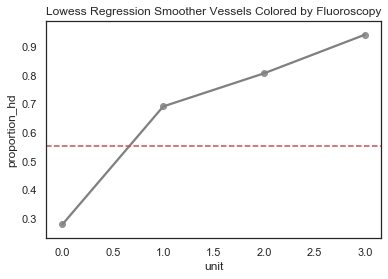

In [351]:
sns.regplot(x="unit", y="proportion_hd", data=calculate_proportions_metric('vessels_fluor'), lowess=True, color='grey').set_title("Lowess Regression Smoother Vessels Colored by Fluoroscopy")
plt.axhline(y=hd_rate, color='r', linestyle='dashed')
plt.show()

##### Test statistic for metric independent variables

For the metric variables, it is necessary to determine whether they are normally distributed before choosing a test (Pahlke 2021). The **Shapiro-Wilk test** can be used to **test for normal distribution** (Hemmerich 2021b).

In [352]:
# Shapiro Wilk: tests  null hypothesis that data was drawn from normal distribution (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
# na-values had to be temporarily dropped to perform the test
shapiro_wilk = pd.DataFrame(columns = ['feature_1', 'feature_2', 'shapiro_wilk_statistic', 'p-value', 'normal_distribution'])

for i in metric_vars:
    statistic, p = shapiro(data[i].dropna())
    alpha = 0.05
    if p > alpha:
        norm_distr = True
    else:
        norm_distr = False
    
    shapiro_wilk.loc[len(shapiro_wilk)] = ['heart_disease', i, round(statistic, 3), round(p, 3), norm_distr]

In [353]:
shapiro_wilk

,feature_1,feature_2,shapiro_wilk_statistic,p-value,normal_distribution
0,heart_disease,vessels_fluor,0.710,0.000,False
1,heart_disease,chol,0.863,0.000,False
2,heart_disease,age,0.993,0.001,False
3,heart_disease,blood_press,0.953,0.000,False
4,heart_disease,max_heart_rate,0.991,0.000,False
5,heart_disease,ST_depression,0.853,0.000,False


Because the variables are not normally distributed, the **nonparametric Mann-Whitney-U-Test** is used to compare the heart_disease / no_disease groups regarding the metric variables (Pahlke 2021).

The t-test cannot be used in this scenario, as a few requirements are not fulfilled. The data does not follow a normal distribution, there are outliers in the data (see box plots in section Exploratory Data Analysis) and the variance would have to be the same in both groups (this has not been tested) (Hemmerich 2021c).

In [354]:
# Mann-Whitney-U-Test
# modified from (Brownlee 2018c)
mwu_statistics = pd.DataFrame(columns = ['feature_1', 'feature_2', 'mwu_statistic', 'p-value', 'group_difference'])

for i in metric_vars: 
    data1 = data[i][data['heart_disease']==0]
    data2 = data[i][data['heart_disease']==1]
    
    statistic, p = mannwhitneyu(data1, data2)
    alpha = 0.05
    if p > alpha:
        diff = False
    else:
        diff = True
    
    mwu_statistics.loc[len(mwu_statistics)] = ['heart_disease', i, statistic.round(3), p.round(3), diff]

In [355]:
mwu_statistics.sort_values(by=['p-value'])

,feature_1,feature_2,mwu_statistic,p-value,group_difference
1,heart_disease,chol,53686.0,0.000,True
2,heart_disease,age,44574.0,0.000,True
4,heart_disease,max_heart_rate,39952.0,0.000,True
5,heart_disease,ST_depression,40541.0,0.000,True
3,heart_disease,blood_press,59567.5,0.005,True
0,heart_disease,vessels_fluor,64389.5,0.185,False


### Relationship between predictors<a name="pred_pred"></a>

#### Chi-squared test among categorical predictors

In [356]:
# Chi Squared test for categorical variables
# modified from (Brownlee 2018b)

chi_statistics = pd.DataFrame(columns = ['feature_1', 'feature_2', 'chi2', 'p-value', 'dependent'])

for i in combinations(categorical_vars, 2):
    contigency = pd.crosstab(data[i[0]], data[i[1]])

    chi2_stat, p, dof, expected = chi2_contingency(contigency)

    prob = 0.95
    critical = chi2.ppf(prob, dof)
    alpha = 1.0 - prob
    if p <= alpha:
        dep= True
    else:
        dep= False

    chi_statistics.loc[len(chi_statistics)] = [i[0], i[1], chi2_stat.round(3), p.round(3), dep]

In [357]:
significant_chi_statistics = chi_statistics.loc[chi_statistics['p-value']<=alpha]

In [358]:
significant_chi_statistics.sort_values(by=['chi2'], ascending=False) # variables are dependent on each other

,feature_1,feature_2,chi2,p-value,dependent
8,chest_pain,exercise_angina,132.540,0.000,True
18,exercise_angina,slope_ST,59.126,0.000,True
5,sex,thal,54.693,0.000,True
19,exercise_angina,thal,41.876,0.000,True
10,chest_pain,thal,41.754,0.000,True
20,slope_ST,thal,41.124,0.000,True
9,chest_pain,slope_ST,37.888,0.000,True
17,restecg,thal,25.379,0.000,True
0,sex,chest_pain,25.294,0.000,True
11,blood_sugar,restecg,18.115,0.000,True


#### Correlations between metric predictors

In [359]:
corr_metric_predictors = data[metric_vars].corr()
corr_metric_predictors.style.background_gradient(cmap="coolwarm").set_precision(2)

,vessels_fluor,chol,age,blood_press,max_heart_rate,ST_depression
vessels_fluor,1.00,0.06,0.35,0.06,-0.27,0.27
chol,0.06,1.00,-0.07,0.15,0.26,0.05
age,0.35,-0.07,1.00,0.25,-0.36,0.25
blood_press,0.06,0.15,0.25,1.00,-0.11,0.16
max_heart_rate,-0.27,0.26,-0.36,-0.11,1.00,-0.16
ST_depression,0.27,0.05,0.25,0.16,-0.16,1.00


In [360]:
order_corr = corr_metric_predictors.unstack().sort_values(ascending=False).drop_duplicates()
order_corr

vessels_fluor   vessels_fluor     1.000000
age             vessels_fluor     0.351501
vessels_fluor   ST_depression     0.273367
chol            max_heart_rate    0.261049
age             blood_press       0.254745
ST_depression   age               0.254358
                blood_press       0.162234
chol            blood_press       0.149373
vessels_fluor   blood_press       0.060212
                chol              0.058580
ST_depression   chol              0.054896
age             chol             -0.065784
blood_press     max_heart_rate   -0.105245
max_heart_rate  ST_depression    -0.162357
                vessels_fluor    -0.268457
age             max_heart_rate   -0.363438
dtype: float64

Plots for variables with highest-ranking correlations

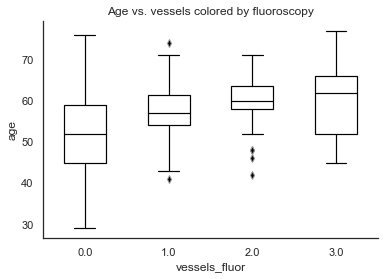

In [361]:
# box plot vessels_fluor - age
sns.set(style="white")
sns.boxplot(x='vessels_fluor',y='age',data=data, color='white', width=0.5, linewidth=1.2, **PROPS)
plt.title("Age vs. vessels colored by fluoroscopy")
sns.despine()

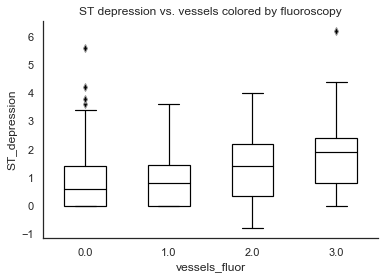

In [362]:
# box plot vessels_fluor - ST_depression
sns.set(style="white")
sns.boxplot(x='vessels_fluor',y='ST_depression',data=data, color='white', width=0.5, linewidth=1.2, **PROPS)
plt.title("ST depression vs. vessels colored by fluoroscopy")
sns.despine()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


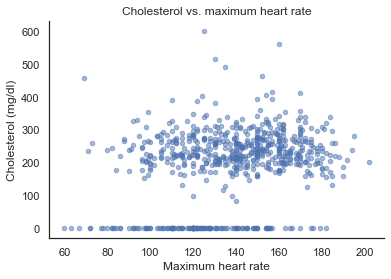

In [363]:
# scatter plot Cholesterol vs. heart rate
data.plot(kind="scatter", x="max_heart_rate", y="chol", alpha=0.5)
plt.xlabel("Maximum heart rate")
plt.ylabel("Cholesterol (mg/dl)")
plt.title("Cholesterol vs. maximum heart rate")
sns.despine()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


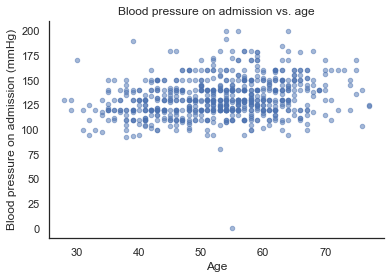

In [364]:
# scatter plot Blood pressure on admission vs. age
data.plot(kind="scatter", x="age", y="blood_press", alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Blood pressure on admission (mmHg)")
plt.title("Blood pressure on admission vs. age")
sns.despine()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


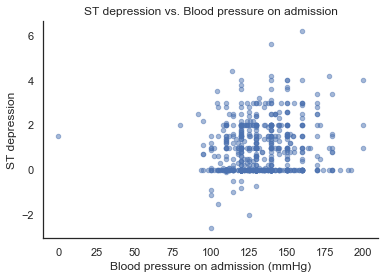

In [365]:
# scatter plot Blood pressure on admission vs. ST depression
data.plot(kind="scatter", x="blood_press", y="ST_depression", alpha=0.5)
plt.xlabel("Blood pressure on admission (mmHg)")
plt.ylabel("ST depression")
plt.title("ST depression vs. Blood pressure on admission")
sns.despine()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


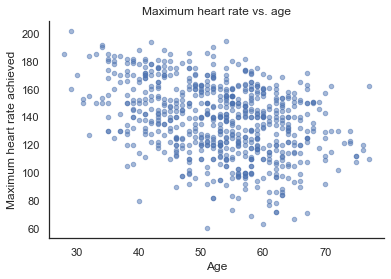

In [366]:
# scatter plot Maximum heart rate vs. age
data.plot(kind="scatter", x="age", y="max_heart_rate", alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Maximum heart rate achieved")
plt.title("Maximum heart rate vs. age")
sns.despine()

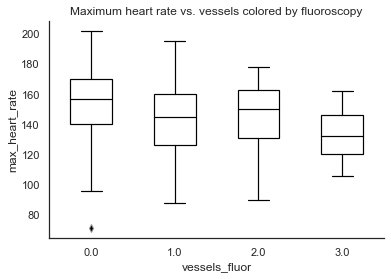

In [367]:
# box plot vessels_fluor - max heart rate
sns.set(style="white")
sns.boxplot(x='vessels_fluor',y='max_heart_rate',data=data, color='white', width=0.5, linewidth=1.2, **PROPS)
plt.title("Maximum heart rate vs. vessels colored by fluoroscopy")
sns.despine()

#### Relationship between metric and categorical predictors

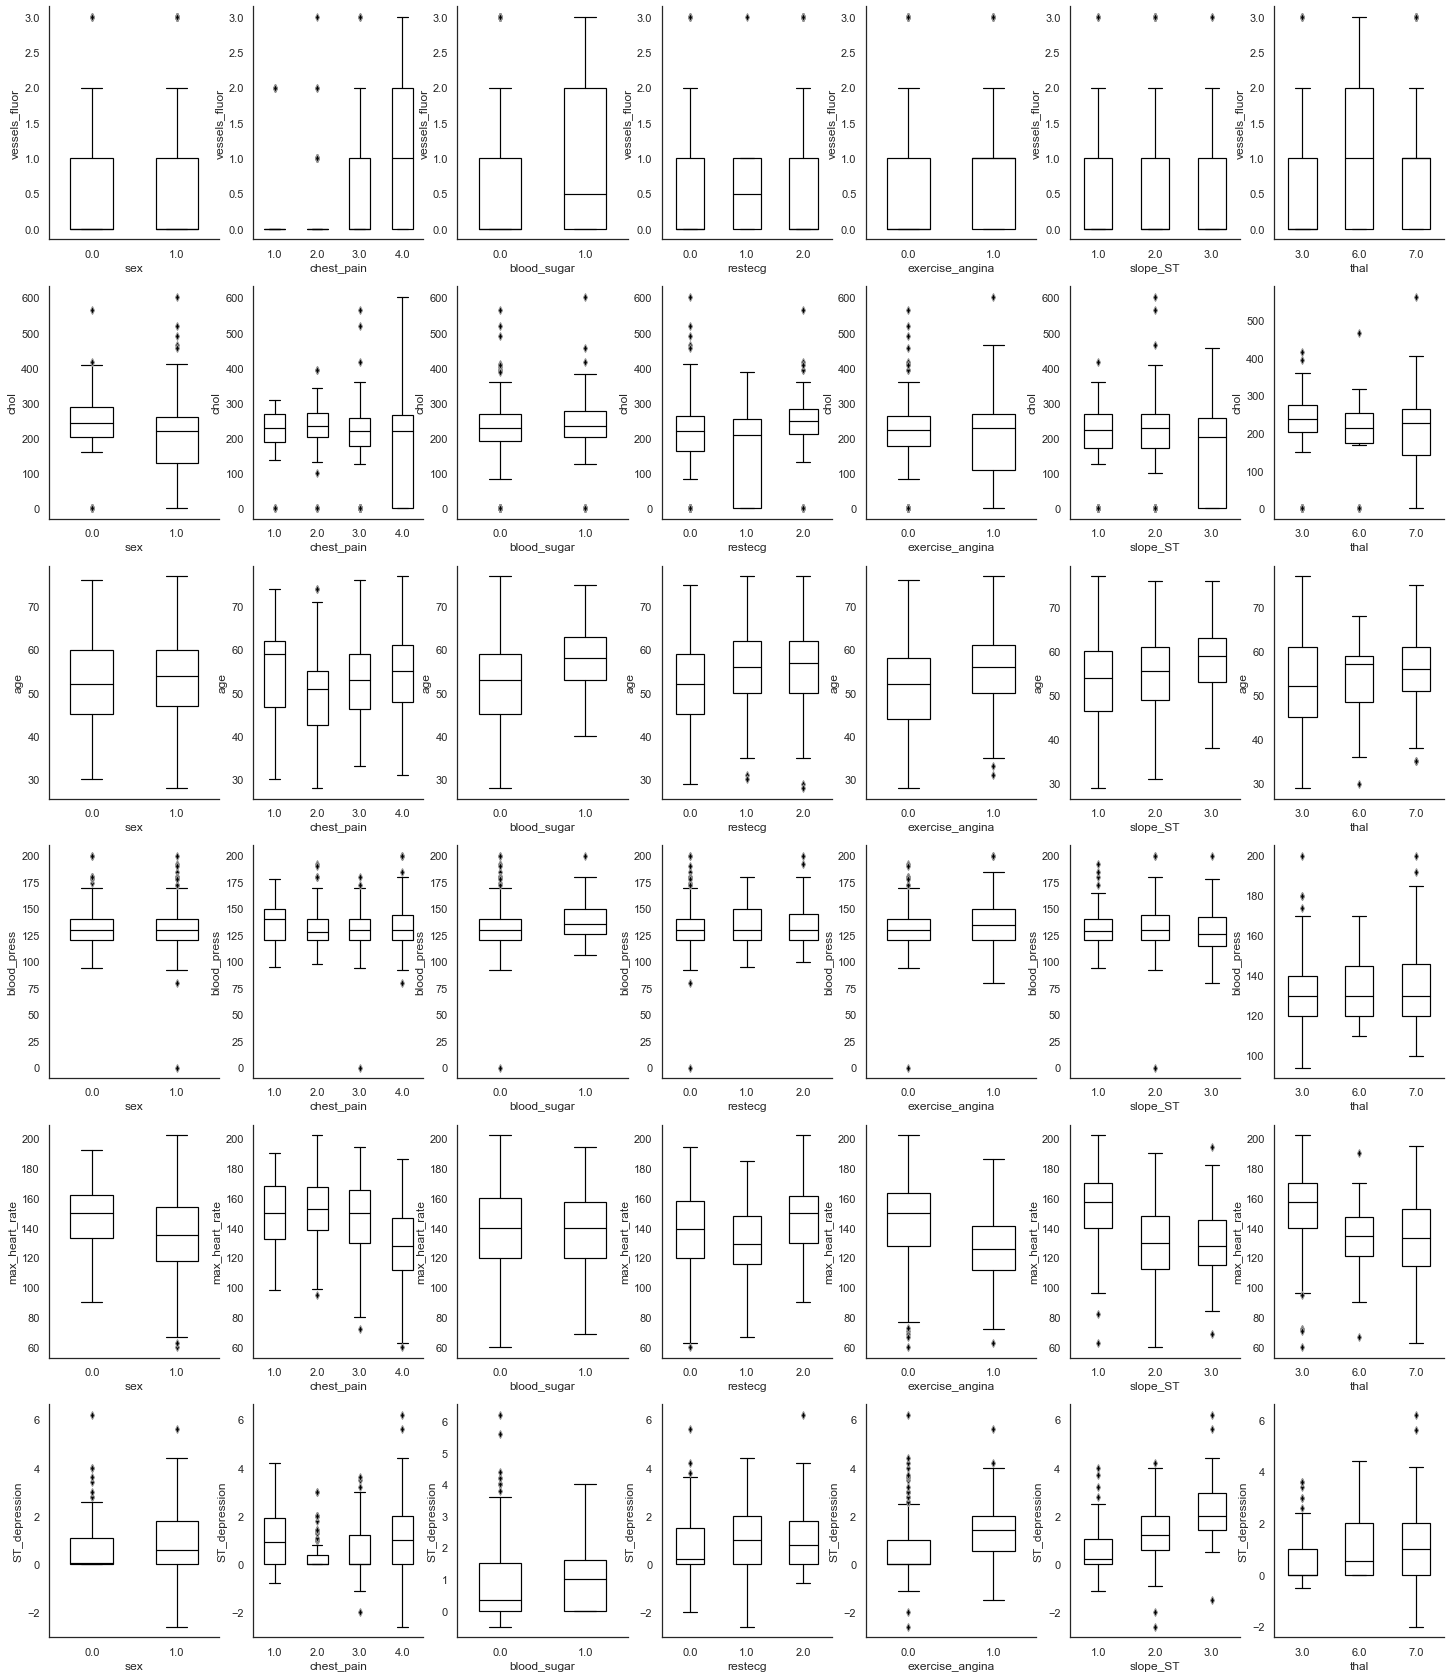

In [368]:
# box plots for metric / categorical predictor relationships
sns.set(style="white")
f, axes = plt.subplots(nrows=len(metric_vars), ncols=len(categorical_vars), figsize=(25,30))
for i in categorical_vars:
    for j in metric_vars:
        sns.boxplot(x=i, y=j, ax=axes[metric_vars.index(j),categorical_vars.index(i)], data=data, color='white', width=0.5, linewidth=1.2, **PROPS)
        sns.despine()

### further possible questions<a name="further_q"></a>

#### 1. Are women with myocardial infarction more frequently asymptomatic than men?

In [369]:
# selecting subgroup of patients with heart_disease
hd_patients = data[data.heart_disease == 1]
hd_patients.shape

(407, 19)

It is visible that there were fewer women than men in the sample. The occurence of heart disease can be seen for both gender groups.

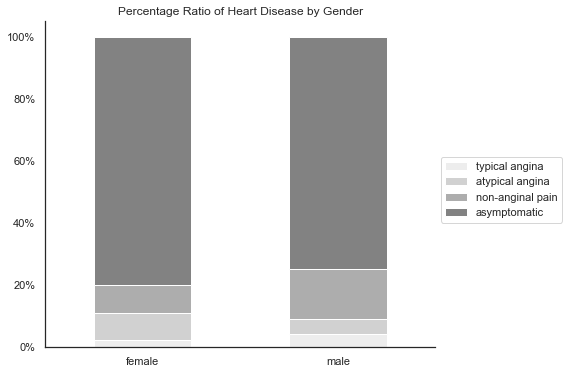

In [370]:
# percentage plot of heart disease by gender
with sns.color_palette("Greys"):
    ax=hd_patients.groupby(['sex','chest_pain']).size().groupby(level=0).apply(
        lambda x: 100 * x / x.sum()
    ).unstack().plot(kind='bar',stacked=True, figsize=(7, 6))
    ax.set_xticklabels(['female', 'male'],  rotation = 0)
    ax.set_xlabel("")
    ax.set_title("Percentage Ratio of Heart Disease by Gender")
    plt.legend(["typical angina", "atypical angina", "non-anginal pain", "asymptomatic"], bbox_to_anchor=(1, 0.6))
    sns.despine()
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()

In [371]:
# calculate proportions asymptomatic
asymptomatic_female = hd_patients.groupby(['sex','chest_pain']).size()[0,4]
asymptomatic_male = hd_patients.groupby(['sex','chest_pain']).size()[1,4]

hd_patients_female = hd_patients.groupby('sex').size()[0]
hd_patients_male = hd_patients.groupby('sex').size()[1]

proportion_asymp_female = asymptomatic_female/hd_patients_female
proportion_asymp_male = asymptomatic_male/hd_patients_male

ci_low_f, ci_upp_f = smp.proportion_confint(asymptomatic_female, hd_patients_female, alpha=0.05, method='normal')
ci_low_m, ci_upp_m = smp.proportion_confint(asymptomatic_male, hd_patients_male, alpha=0.05, method='normal')

proportions = {'gender':['female', 'male'],
            'proportion':[proportion_asymp_female, proportion_asymp_male],
            'ci_low':[ci_low_f, ci_low_m],
              'ci_upp':[ci_upp_f, ci_upp_m]}
proportions = pd.DataFrame(proportions)
proportions

,gender,proportion,ci_low,ci_upp
0,female,0.800000,0.683130,0.916870
1,male,0.748619,0.703931,0.793307


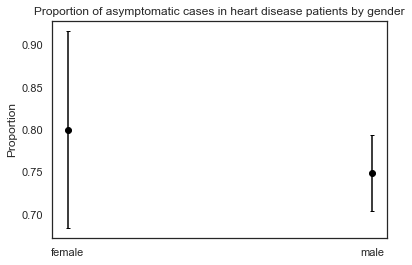

In [372]:
# plot proportions asymptomatic
yerr = [np.subtract(proportions.proportion, proportions.ci_low), np.subtract(proportions.ci_upp, proportions.proportion)]
plt.errorbar(proportions.gender, proportions.proportion, fmt='o', yerr=yerr, color='black', capsize=2)
plt.title("Proportion of asymptomatic cases in heart disease patients by gender")
plt.ylabel("Proportion")
plt.show()

There does not seem to be a difference in proportion of asymptomatic cases between men and women.

In [373]:
# calculate proportions non-anginal pain
non_anginal_female = hd_patients.groupby(['sex','chest_pain']).size()[0,3]
non_anginal_male = hd_patients.groupby(['sex','chest_pain']).size()[1,3]

hd_patients_female = hd_patients.groupby('sex').size()[0]
hd_patients_male = hd_patients.groupby('sex').size()[1]

proportion_non_ang_female = non_anginal_female/hd_patients_female
proportion_non_ang_male = non_anginal_male/hd_patients_male

ci_low_f, ci_upp_f = smp.proportion_confint(non_anginal_female, hd_patients_female, alpha=0.05, method='normal')
ci_low_m, ci_upp_m = smp.proportion_confint(non_anginal_male, hd_patients_male, alpha=0.05, method='normal')

proportions = {'gender':['female', 'male'],
            'proportion':[proportion_non_ang_female, proportion_non_ang_male],
            'ci_low':[ci_low_f, ci_low_m],
              'ci_upp':[ci_upp_f, ci_upp_m]}
proportions_non_anginal = pd.DataFrame(proportions)
proportions_non_anginal

,gender,proportion,ci_low,ci_upp
0,female,0.088889,0.005741,0.172037
1,male,0.160221,0.122435,0.198007


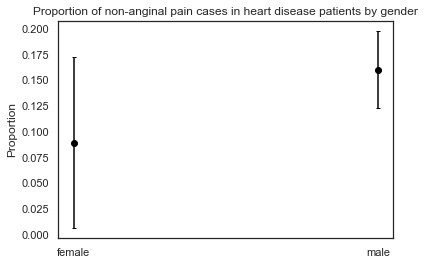

In [374]:
# plot proportions non-anginal pain
yerr = [np.subtract(proportions_non_anginal.proportion, proportions_non_anginal.ci_low), np.subtract(proportions_non_anginal.ci_upp, proportions_non_anginal.proportion)]
plt.errorbar(proportions_non_anginal.gender, proportions_non_anginal.proportion, fmt='o', yerr=yerr, color='black', capsize=2)
plt.title("Proportion of non-anginal pain cases in heart disease patients by gender")
plt.ylabel("Proportion")
plt.show()

There does not seem to be a difference in proportion of non-anginal pain cases between men and women as the confidence intervals overlap and the scale of the plot only ranges between 0 and 0.2, which is only a small fraction.

#### 2. Do elevated blood pressure, elevated blood sugar and high cholesterol occur together more often?

In [375]:
corr_trias = data[['blood_press', 'chol', 'blood_sugar']].corr()

In [376]:
corr_trias.style.background_gradient()

,blood_press,chol,blood_sugar
blood_press,1.000000,0.149373,0.144072
chol,0.149373,1.000000,0.028170
blood_sugar,0.144072,0.028170,1.000000


There does not seem to be a particular correlation between elevated blood pressure, elevated blood sugar and high cholesterol in the data.

## Preprocessing<a name="preprocessing"></a>

In [377]:
# delete columns with binned form of variables
data = data[data.columns.drop(list(data.filter(regex='cut')))]

In [378]:
data_p = data.copy()

### Data Cleaning<a name="clean"></a>

#### Missing Values

In [379]:
data_p.isnull().sum()/data_p.shape[0]

age                0.000000
sex                0.000000
chest_pain         0.000000
blood_press        0.062500
chol               0.036685
blood_sugar        0.105978
restecg            0.002717
max_heart_rate     0.057065
exercise_angina    0.057065
ST_depression      0.066576
slope_ST           0.327446
vessels_fluor      0.650815
thal               0.510870
heart_disease      0.000000
dtype: float64

In [380]:
missing = data_p.isna().any()

In [381]:
# percentage of missing values for different features
missing_cols = list(missing[missing == True].index)
length = data_p.shape[0]
print("Total entries: {} rows.".format(length))
for col in missing_cols:
    no_missing = data_p[col].isna().sum()
    print("{}% of data ({} entries) missing for '{}'.".format(round(100*no_missing/length, 2), no_missing, col))

Total entries: 736 rows.
6.25% of data (46 entries) missing for 'blood_press'.
3.67% of data (27 entries) missing for 'chol'.
10.6% of data (78 entries) missing for 'blood_sugar'.
0.27% of data (2 entries) missing for 'restecg'.
5.71% of data (42 entries) missing for 'max_heart_rate'.
5.71% of data (42 entries) missing for 'exercise_angina'.
6.66% of data (49 entries) missing for 'ST_depression'.
32.74% of data (241 entries) missing for 'slope_ST'.
65.08% of data (479 entries) missing for 'vessels_fluor'.
51.09% of data (376 entries) missing for 'thal'.


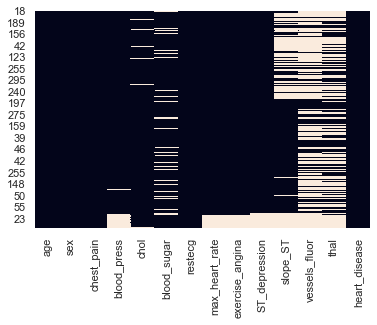

In [382]:
sns.heatmap(data_p.isnull(), cbar=False)
plt.show()

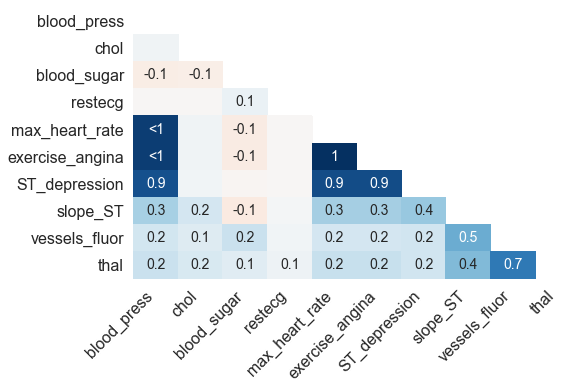

In [383]:
missingno.heatmap(data_p, figsize=(8,5), cbar=False)
plt.show()

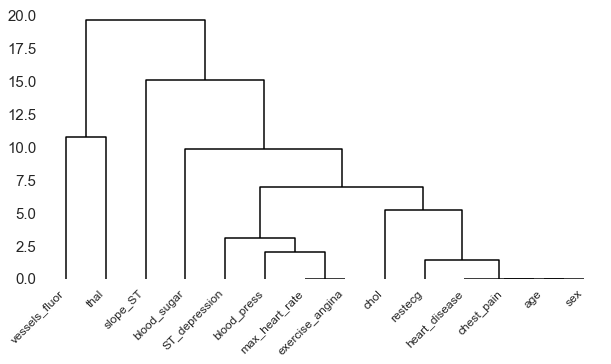

In [384]:
missingno.dendrogram(data_p, orientation="top", figsize=(10,5), fontsize=12);

It can be seen that missing values for exercise_angina, max_heart_rate, blood_press and ST_depression often occur together. This may be because some examinations like a cardiac stress test / ergometry may not have been performed. Thus, the results from these tests are not present in these patients.

Also, missing values for vessels_fluor and thal seem to be correlated. These two examinations may not have been conducted in a number of patients

##### Imputing missing values (metric variables)

If the amount of data that is missing for a column does not exceed 20%, it is possible to impute values. In the following, the k-Nearest Neighbours algorithm will be used for the imputation of missing values (Kuhn and Johnson 2019).

In [385]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit(data_p)
imputed_data = pd.DataFrame(imputer.transform(data_p), columns=data_p.columns)

In [386]:
data_p[['blood_press', 'chol', 'max_heart_rate', 'ST_depression']] = imputed_data[['blood_press', 'chol', 'max_heart_rate', 'ST_depression']].values

Imputing missing values for 'vessels_fluor' with a constant value (999), assuming that the examination was not performed.

In [387]:
imp = SimpleImputer(strategy="constant", fill_value=999)
data_p['vessels_fluor'] = imp.fit_transform(data_p['vessels_fluor'].values.reshape(-1, 1))

##### One-Hot-Encoding of categorical variables with many missing values

Those are
- 'blood_sugar' (already dummy encoded, but needs category for missing values)
- 'exercise_angina' (already dummy encoded, but needs category for missing values)
- 'slope_ST'
- 'thal'

In [388]:
one_hot_enc = OneHotEncoder(sparse=False)

In [389]:
data_p_one_hot = one_hot_enc.fit_transform(data_p[['blood_sugar', 'exercise_angina', 'slope_ST', 'thal']])

In [390]:
one_hot_enc.categories_ 

[array([ 0.,  1., nan]),
 array([ 0.,  1., nan]),
 array([ 1.,  2.,  3., nan]),
 array([ 3.,  6.,  7., nan])]

In [391]:
columns_enc_cat = one_hot_enc.get_feature_names(['blood_sugar', 'exercise_angina', 'slope_ST', 'thal'])

In [392]:
data_p_one_hot = pd.DataFrame(data_p_one_hot, columns=columns_enc_cat)

In [393]:
# joining data_p dataframe with encoded variables' dataframe
data_p_enc = data_p.reset_index(drop=True)
data_p_enc = pd.concat([data_p_enc, data_p_one_hot], axis=1)

In [394]:
# dropping original columns
data_p_enc = data_p_enc.drop(['blood_sugar', 'exercise_angina', 'slope_ST', 'thal'], axis=1)

In [395]:
data_p_enc.shape

(736, 24)

##### Deletion of rows with missing values

Because restecg only has a small number of missing entries (2 entries), these rows will be deleted.

In [396]:
# delete those two rows with nan restecg
# dropping rows where restecg is NaN
data_p_enc = data_p_enc.dropna(subset=["restecg"])

In [397]:
data_p_enc.shape

(734, 24)

#### Inconsistent Values, invalid values

The data contains invalid values for cholesterol and blood pressure (values of 0 are not possible). These values will also be imputed.

In [398]:
# setting invalid values to nan temporarily
data_p_enc.chol.loc[data_p_enc['chol']==0] = np.nan
data_p_enc.blood_press.loc[data_p_enc['blood_press']==0] = np.nan

In [399]:
# imputing these invalid values
imputer_zeros = KNNImputer(n_neighbors=5)
imputer_zeros.fit(data_p_enc)
imputed_zeros_data = pd.DataFrame(imputer_zeros.transform(data_p_enc), columns=data_p_enc.columns)

In [400]:
data_p_enc[['blood_press', 'chol']] = imputed_zeros_data[['blood_press', 'chol']].values

### Data Transformation<a name="transform"></a>

In [401]:
data_transf = data_p_enc.copy()

#### Scaling

Scaling is useful for models that require the predictors to have common units (Kuhn and Johnson 2019). These are, among others methods, k-nearest neighbors, support vector machines, regression models and neural networks. Tree-based algorithms, on the other hand, are insensitive to different scales of features. The values of the metric variables are going to be centered and scaled, so that they have a common mean of zero and standard deviation of one. This maintains the original distribution, but outliers remain, if they do exist (Fussan 2020a).

In [402]:
metric_vars

['vessels_fluor',
 'chol',
 'age',
 'blood_press',
 'max_heart_rate',
 'ST_depression']

In [403]:
scaler = StandardScaler().fit(data_transf[metric_vars])

In [404]:
data_transf[metric_vars] = scaler.transform(data_transf[metric_vars])
data_transf.head()

,age,sex,chest_pain,blood_press,chol,restecg,max_heart_rate,ST_depression,vessels_fluor,heart_disease,...,exercise_angina_1.0,exercise_angina_nan,slope_ST_1.0,slope_ST_2.0,slope_ST_3.0,slope_ST_nan,thal_3.0,thal_6.0,thal_7.0,thal_nan
0,-0.780179,1.0,4.0,-1.768994,-0.457808,1.0,-0.160288,-3.269091,0.734019,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.282846,1.0,3.0,-0.389305,-0.117233,0.0,-1.530054,-2.704065,0.734019,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.205389,1.0,4.0,-1.493056,-0.236995,0.0,-0.355969,-2.233211,0.734019,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.630599,1.0,3.0,-1.768994,-0.053609,0.0,1.639976,-1.856527,0.734019,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.282846,1.0,4.0,-0.941181,-0.188342,1.0,-2.156233,-1.762356,0.734019,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Encoding of remaining categorical variables

Many models require all predictors to be in numerical form. Categorical variables can be converted to numeric data by creating dummy variables. For each category of the variable, a dummy variable will be created (one hot encoding / less than full rank encoding). This may be an advantage for interpretation of splits created by tree-based models later on. However, there may be drawbacks with linear models (Kuhn and Johnson 2019).

The following categorical variables will be encoded:
- chest_pain
- restecg

already encoded:
- heart_disease

already encoded in process of dealing with missing values:
- blood_sugar
- exercise_angina
- slope_ST
- thal

In [405]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [406]:
data_transf_one_hot = one_hot_encoder.fit_transform(data_transf[['chest_pain', 'restecg']])

In [407]:
one_hot_encoder.categories_ 

[array([1., 2., 3., 4.]), array([0., 1., 2.])]

In [408]:
columns_enc = one_hot_encoder.get_feature_names(['chest_pain', 'restecg'])

In [409]:
data_transf_one_hot = pd.DataFrame(data_transf_one_hot, columns=columns_enc)

In [410]:
# joining data_p dataframe with encoded variables' dataframe
data_transf_enc = data_transf.reset_index(drop=True)
data_transf_enc = pd.concat([data_transf_enc, data_transf_one_hot], axis=1)

In [411]:
# dropping original columns
data_transf_enc = data_transf_enc.drop(['chest_pain', 'restecg'], axis=1)

In [412]:
data_transf_enc.shape

(734, 29)

## Model Training<a name="training"></a>

Different models are tried out and the most promising ones (high accuracy) optimized on their hyperparameters.

In [413]:
train = data_transf_enc.copy()

In [414]:
X_train = train.drop(['heart_disease'], axis=1)
y_train = train['heart_disease']

#### k-Nearest Neighbors

In [415]:
kNN_clf = KNeighborsClassifier(n_neighbors=5)
kNN_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [416]:
scores = cross_val_score(kNN_clf, X_train, y_train, cv=10, scoring="accuracy")
print("scores: ", scores)
print("mean: ", scores.mean())
print("std: ", scores.std())

scores:  [0.7027027  0.7972973  0.78378378 0.78378378 0.89041096 0.91780822
 0.79452055 0.73972603 0.78082192 0.68493151]
mean:  0.787578674564976
std:  0.06912420550060915


##### Optimizing the Model

In [417]:
# range of hyperparameters according to (Brownlee 2019b)
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
param_grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)

In [418]:
gs_kNN_clf = GridSearchCV(kNN_clf, param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

In [419]:
gs_kNN_clf.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(1, 21, 2),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [420]:
gs_kNN_clf.best_score_

0.7751589160254265

In [421]:
gs_kNN_clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}

#### Support vector machine

In [422]:
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [423]:
scores = cross_val_score(svc, X_train, y_train, cv=10, scoring="accuracy")
print("scores: ", scores)
print("mean: ", scores.mean())
print("std: ", scores.std())

scores:  [0.67567568 0.86486486 0.77027027 0.85135135 0.90410959 0.90410959
 0.82191781 0.79452055 0.76712329 0.68493151]
mean:  0.8038874490929284
std:  0.07716433627371617


##### Optimizing the Model

In [424]:
# range of hyperparameters according to (Brownlee 2019b)
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
param_grid = dict(kernel=kernel,C=C,gamma=gamma)

In [425]:
gs_svc = GridSearchCV(svc, param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

In [426]:
gs_svc.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


GridSearchCV(cv=3, estimator=SVC(kernel='linear', probability=True), n_jobs=-1,
             param_grid={'C': [50, 10, 1.0, 0.1, 0.01], 'gamma': ['scale'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [427]:
gs_svc.best_score_

0.7533846325415413

In [428]:
gs_svc.best_params_

{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}

#### Logistic Regression

In [429]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [430]:
scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring="accuracy")

print("scores: ", scores)
print("mean: ", scores.mean())
print("std: ", scores.std())

scores:  [0.66216216 0.83783784 0.7972973  0.83783784 0.91780822 0.93150685
 0.82191781 0.78082192 0.79452055 0.67123288]
mean:  0.8052943354313216
std:  0.08379838406591052


##### Optimizing the Model

In [431]:
# range of hyperparameters according to (Jee 2021)
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

In [432]:
gs_log_reg = GridSearchCV(log_reg, param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

In [433]:
gs_log_reg.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [2000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy', verbose=2)

In [434]:
gs_log_reg.best_score_

0.7587877774060444

In [435]:
gs_log_reg.best_params_

{'C': 0.00026366508987303583,
 'max_iter': 2000,
 'penalty': 'l2',
 'solver': 'liblinear'}

#### SGD Classifier

In [436]:
from sklearn.linear_model import SGDClassifier
SGD_clf = SGDClassifier(random_state=42)
SGD_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [437]:
scores = cross_val_score(SGD_clf, X_train, y_train, cv=10, scoring="accuracy")
print("scores: ", scores)
print("mean: ", scores.mean())
print("std: ", scores.std())

scores:  [0.71621622 0.78378378 0.77027027 0.82432432 0.7260274  0.93150685
 0.78082192 0.76712329 0.79452055 0.64383562]
mean:  0.7738430211032951
std:  0.0710973668556632


#### Decision Tree

In [438]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [439]:
scores = cross_val_score(dt_clf, X_train, y_train, cv=10, scoring="accuracy")
print("scores: ", scores)
print("mean: ", scores.mean())
print("std: ", scores.std())

scores:  [0.67567568 0.72972973 0.55405405 0.54054054 0.71232877 0.60273973
 0.75342466 0.67123288 0.52054795 0.67123288]
mean:  0.6431506849315068
std:  0.07887237149620832


#### Neural Network

In [440]:
nn_clf = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=42)
nn_clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=42)

In [441]:
scores = cross_val_score(nn_clf, X_train, y_train, cv=10, scoring="accuracy")

print("scores: ", scores)
print("mean: ", scores.mean())
print("std: ", scores.std())

scores:  [0.71621622 0.81081081 0.71621622 0.78378378 0.75342466 0.82191781
 0.7260274  0.7260274  0.71232877 0.63013699]
mean:  0.7396890040725658
std:  0.05308328842813075


#### Random Forest

In [442]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [443]:
scores = cross_val_score(forest_clf, X_train, y_train, cv=10, scoring="accuracy")

print("scores: ", scores)
print("mean: ", scores.mean())
print("std: ", scores.std())

scores:  [0.72972973 0.83783784 0.75675676 0.78378378 0.84931507 0.89041096
 0.83561644 0.79452055 0.69863014 0.67123288]
mean:  0.7847834135505367
std:  0.06704372102782422


##### Optimizing the Model

In [444]:
# range of hyperparameters according to (Technische Hochschule Deggendorf 2020)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4,6,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [445]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 8], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [446]:
gs_forest_clf = GridSearchCV(forest_clf, param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

In [447]:
gs_forest_clf.fit(X_train, y_train)

Fitting 3 folds for each of 640 candidates, totalling 1920 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 14, 18, 23, 27, 32, 36, 41, 45,
                                          50]},
             scoring='accuracy', verbose=2)

In [448]:
gs_forest_clf.best_score_

0.7001394000223041

In [449]:
gs_forest_clf.best_params_

{'bootstrap': False,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 23}

In [450]:
gs_forest_clf.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=2, n_estimators=23,
                       random_state=42)

## Model Evaluation<a name="eval"></a>

In [451]:
opt_models = pd.DataFrame(columns = ['model', 'best_score_', 'F1_score', 'ROC_AUC_score'])
model_names = [gs_kNN_clf, gs_svc, gs_log_reg, gs_forest_clf]

for model in model_names:
    opt_models.loc[len(opt_models)] = [model.best_estimator_, 
                                       model.best_score_, 
                                       f1_score(y_train, model.predict(X_train)), 
                                       roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])]

In [452]:
opt_models = opt_models.sort_values(by=['best_score_'], ascending=False).reset_index(drop=True)
opt_models

,model,best_score_,F1_score,ROC_AUC_score
0,"KNeighborsClassifier(metric='manhattan', n_nei...",0.775159,0.859927,0.906304
1,"LogisticRegression(C=0.00026366508987303583, m...",0.758788,0.822844,0.863087
2,"SVC(C=0.1, kernel='sigmoid', probability=True)",0.753385,0.829268,0.881879
3,"(DecisionTreeClassifier(max_depth=2, max_featu...",0.700139,0.845266,0.885249


In [453]:
test = strat_test_set.copy().drop(['num'], axis=1)

### Data preprocessing for test set

#### Imputation of missing values

In [454]:
imputed_test = pd.DataFrame(imputer.transform(test), columns=test.columns)

In [455]:
test[['blood_press', 'chol', 'max_heart_rate', 'ST_depression']]=imputed_test[['blood_press', 'chol', 'max_heart_rate', 'ST_depression']].values

In [456]:
test['vessels_fluor'] = imp.transform(test['vessels_fluor'].values.reshape(-1, 1))

In [457]:
test_one_hot = one_hot_enc.transform(test[['blood_sugar', 'exercise_angina', 'slope_ST', 'thal']])

In [458]:
columns_enc_cat

array(['blood_sugar_0.0', 'blood_sugar_1.0', 'blood_sugar_nan',
       'exercise_angina_0.0', 'exercise_angina_1.0',
       'exercise_angina_nan', 'slope_ST_1.0', 'slope_ST_2.0',
       'slope_ST_3.0', 'slope_ST_nan', 'thal_3.0', 'thal_6.0', 'thal_7.0',
       'thal_nan'], dtype=object)

In [459]:
test_one_hot = pd.DataFrame(test_one_hot, columns=columns_enc_cat)

In [460]:
# joining dataframe with encoded variables' dataframe
test_enc = test.reset_index(drop=True)
test_enc = pd.concat([test_enc, test_one_hot], axis=1)

In [461]:
# dropping original columns
test_enc = test_enc.drop(['blood_sugar', 'exercise_angina', 'slope_ST', 'thal'], axis=1)

In [462]:
test_enc.shape

(184, 24)

In [463]:
test_enc.isnull().values.any()

False

In [464]:
# setting invalid values to nan temporarily
test_enc.chol.loc[test_enc['chol']==0] = np.nan
test_enc.blood_press.loc[test_enc['blood_press']==0] = np.nan

C:\Users\Alina\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Alina\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [465]:
# imputing these invalid values
imputed_zeros_test = pd.DataFrame(imputer_zeros.transform(test_enc), columns=test_enc.columns)

In [466]:
test_enc[['blood_press', 'chol']] = imputed_zeros_test[['blood_press', 'chol']]

#### Scaling

In [467]:
test_transf = test_enc.copy()

In [468]:
test_transf[metric_vars] = scaler.transform(test_enc[metric_vars])
test_transf.head()

,age,sex,chest_pain,blood_press,chol,restecg,max_heart_rate,ST_depression,vessels_fluor,heart_disease,...,exercise_angina_1.0,exercise_angina_nan,slope_ST_1.0,slope_ST_2.0,slope_ST_3.0,slope_ST_nan,thal_3.0,thal_6.0,thal_7.0,thal_nan
0,-1.630599,1.0,4.0,-1.217118,-0.925631,0.0,0.505027,0.121062,0.734019,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.814358,1.0,4.0,-0.389305,-0.177114,0.0,-1.256101,-0.820647,0.734019,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.920660,1.0,2.0,-0.665243,0.212115,2.0,-1.725735,-0.820647,0.734019,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.389148,1.0,4.0,1.818196,0.867067,2.0,-0.512513,0.121062,-1.357435,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.664778,1.0,3.0,1.343583,0.530234,2.0,-0.582958,0.968601,0.734019,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


#### Encoding remaining categorical variables

In [469]:
test_transf_one_hot = one_hot_encoder.transform(test_transf[['chest_pain', 'restecg']])

In [470]:
test_transf_one_hot = pd.DataFrame(test_transf_one_hot, columns=columns_enc)

In [471]:
# joining data_p dataframe with encoded variables' dataframe
test_transf_enc = test_transf.reset_index(drop=True)
test_transf_enc = pd.concat([test_transf_enc, test_transf_one_hot], axis=1)

In [472]:
# dropping original columns
test_transf_enc = test_transf_enc.drop(['chest_pain', 'restecg'], axis=1)

In [473]:
test_transf_enc.shape

(184, 29)

### Evaluation on the test set and metrics<a name="eval_test"></a>

In [474]:
final_model = opt_models.iloc[0,0]
final_model

KNeighborsClassifier(metric='manhattan', n_neighbors=19)

In [475]:
X_test = test_transf_enc.drop(['heart_disease'], axis=1)
y_test = test_transf_enc['heart_disease']

In [476]:
test_predictions = final_model.predict(X_test)

In [477]:
confusion_matrix(y_test, test_predictions)

array([[67, 15],
       [12, 90]], dtype=int64)

In [478]:
print("accuracy: ", accuracy_score(y_test, test_predictions))

accuracy:  0.8532608695652174


The model has a decent accuracy of 0.85. This means that 85% of all classifications were correct.

In [479]:
print("precision: ", precision_score(y_test, test_predictions))

precision:  0.8571428571428571


Precision describes the precentage of predicted positives that are truly positive. It is oppositely related to sensitivity: when precision rises, sensitivity decreases and vice versa (Géron 2020). Precision is useful in cases when a lot of certainty is needed for taking actions and when we want to avoud making false diagnoses. Overall, when the model predicted heart disease, 86% of these predictions were true. As the model is supposed to be used in a screening scenario, a higher false-positive rate is accepted in favor of detecting as many positives as possible. From a medical perspective, false-negative predictions would have graver consequences than false-positive predictions.

In [480]:
print("recall: ", recall_score(y_test, test_predictions))

recall:  0.8823529411764706


Recall/Sensitivity describes the percentage of true positives that are detected by the model (Géron 2020). This metric is used in cases when it is necessary to recognize all positives (e.g. for screening in medicine, like in this case). Regarding the recognition of heart disease, a recall/sensitivity of 0.88 indicates that 88% of cases were detected by the model.

In [481]:
print("F1 score: ", f1_score(y_test, test_predictions))

F1 score:  0.8695652173913043


The F1-score combines precision and recall into one metric. A high F1 score is only achieved when both precision as well as recall have high values (Géron 2020). As both metrics have comparable values (0.86 and 0.88), an according F1 score of 0.87 is achieved.

## Limitations<a name="limitations"></a>

Some limitations need to be considered in the analysis:
- There was an uneven distribution of groups in the dataset
    - 21% female vs. 79% male
    - 17% with elevated blood sugar / diabetes vs. 83% with normal blood sugar levels
- There were a number of missing values. For some variables, the percentage of missing values was very high (e.g. vessels_fluor had 65.08% missing values).
- A bigger dataset would be desirable.
- Information on further risk factors (smoking, obesity, family history and more) were not provided, which could play an important role in the diagnosis.
- The accuracy of the model may not be sufficient yet to rely on it in practice. Further study is yet needed.

## Conclusion<a name="conclusion"></a>

Identifying patients with coronary heart disease is important to reduce the risk of complications such as myocardial infarction, heart insufficiency and cardiac arrythmias.

The best model in this project (k-Nearest-Neighbors) classified 85% of patients correctly. As 88% of cases with coronary heart disease were detected by the model (sensitivity), it might serve as a first screening attempt, in addition to vigilance by the general practioner or cardiologist. It would be interesting to study the effect of a classification model like this in practice, also regarding its cost-effectiveness: Do the costs for extra cardiac examinations needed for the screening classifier compensate the possible costs of rehabilitation and disability if the screening is not performed?

More training data is needed to improve the model and also more parameters such as smoking (pack years), BMI, medical history, lipoprotein A levels, family anamnesis for coronary heart disease should be included.

## Bibliography<a name="bibliography"></a>

- Amboss (2021). Thalassämie. https://www.amboss.com/de/wissen/Thalass%C3%A4mie/, last access 27.06.2021.
- Betke, K. (1980). Bedeutung und Vorkommen anomaler Hämoglobinvarianten im europäischen Raum. In: Bachmann K.D. et al. (eds) Monatsschrift Kinderheilkunde. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-662-38563-0_4, https://link.springer.com/chapter/10.1007/978-3-662-38563-0_4, last access 27.06.2021.
- Brownlee, Jason (2018a). How to Calculate Parametric Statistical Hypothesis Tests in Python. Machine Learning Mastery. https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/, last access on 26.06.2021.
- Brownlee, Jason (2018b). A Gentle Introduction to the Chi-Squared Test for Machine Learning. Machine Learning Mastery. https://machinelearningmastery.com/chi-squared-test-for-machine-learning/, last access 28.06.2021.
- Brownlee, Jason (2018c). How to Calculate Nonparametric Statistical Hypothesis Tests in Python. Machine Learning Mastery. https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/, last access on 29.06.2021.
- Brownlee, Jason (2019a). How to Perform Feature Selection with Categorical Data. Machine Learning Mastery. https://machinelearningmastery.com/feature-selection-with-categorical-data/, last access 28.06.2021.
- Brownlee, Jason (2019b). Tune Hyperparameters for Classification Machine Learning Algorithms. Machine Learning Mastery. https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/, last access 28.07.2021.
- Brownlee, Jason (2020): Statistical Imputation for Missing Values in Machine Learning. Machine Learning Mastery. https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/, last access 14.07.2021.
- Busch MA, Kuhnert R (2017). 12-Monats-Prävalenz einer koronaren Herzkrankheit in Deutschland. Journal of Health Monitoring 2(1): 64–69 DOI 10.17886/RKI-GBE-2017-009ISSN 2511-2708, https://www.rki.de/DE/Content/Gesundheitsmonitoring/Gesundheitsberichterstattung/GBEDownloadsJ/FactSheets/JoHM_2017_01_gesundheitliche_lage4.pdf?__blob=publicationFile, last access on 27.07.2021.
- Fussan, Alexander (2020a). Data Preprocessing & Feature Engineering [Handout]. In: TS505.001H, 22.11.2020, VHS Tempelhof-Schoeneberg.
- Fussan, Alexander (2020b). Data Science Summer School – Intelligente Datenanalysen und effektive Datenkommunikation [Handout]. In: TS505.002S, 17.-21.08.2020, VHS Tempelhof-Schoeneberg.
- Gárate-Escamila, A. K., El Hassani, A. H., & Andrès, E. (2020). Classification models for heart disease prediction using feature selection and PCA. Informatics in Medicine Unlocked, 19, 100330.
- Géron, Aurélien (2020). Praxiseinstieg Machine Learning mit Scikit-Learn, Keras und TensorFlow: Konzepte, Tools und Techniken für intelligente Systeme (Aktuell zu TensorFlow 2). Deutschland, Dpunkt.Verlag GmbH.
- Hemmerich, Wanja (2020). Chi-Quadrat-Test. MatheGuru. https://matheguru.com/stochastik/chi-quadrat-test.html, last access on 28.06.2021.
- Hemmerich, Wanja (2021a). χ² (Chi-Quadrat) Test für Unabhängigkeit. StatistikGuru. https://statistikguru.de/spss/chi-quadrat-test-unabhaengigkeit/einleitung-6.html, last access on 28.06.2021.
- Hemmerich, Wanja (2021b). Prüfung auf Normalverteilung, Variablen in SPSS auf Normalverteilung Prüfen. https://statistikguru.de/spss/vorraussetzungen-ueberpruefen/pruefung-auf-normalverteilung/einleitung-7.html, last access on 29.06.2021.
- Hemmerich, Wanja (2021c). Ungepaarter t-Test: Voraussetzungen. https://statistikguru.de/spss/ungepaarter-t-test/voraussetzungen-9.html, last access on 29.06.2021
- Jee, Ken (2021): Titanic Project Example. https://www.kaggle.com/kenjee/titanic-project-example, last access on 28.07.2021.
- Kohne, Elisabeth (2011). Hemoglobinopathies: Clinical manifestations, diagnosis, and treatment. Dtsch Arztebl Int 2011; 108(31–32): 532–40. DOI: 10.3238/arztebl.2011.0532
- Kuhn, Max; Johnson, Kjell (2019). Feature engineering and selection: A practical approach for predictive models. Chapman & Hall/CRC Data Science Series, CRC Press.
- Pahlke, Friedrich (2021). Statistische Tests – Wann benutze ich welches Verfahren?. Evidat. https://www.evidat.com/faq/test-method-selection, last access on 26.06.2021.
- Pereira, N. (2020). Using machine learning classification methods to detect the presence of heart disease. Masters Dissertation. Technological University Dublin. https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1226&context=scschcomdis, last access on 28.06.2021.
- Porto, R.; Molina, J.M.; Berlanga, A.; Patricio, M.A. (2021). Minimum Relevant Features to Obtain Explainable Systems for Predicting Cardiovascular Disease Using the Statlog Data Set.Appl. Sci.2021,11,1285.  https://doi.org/10.3390/app11031285
- Rasool, A., Tao, R., Kashif, K., Khan, W., Agbedanu, P., & Choudhry, N. (2020). Statistic Solution for Machine Learning to Analyze Heart Disease Data. In Proceedings of the 2020 12th International Conference on Machine Learning and Computing (pp. 134-139). https://www.researchgate.net/profile/Abdur-Rasool/publication/341665309_Statistic_Solution_for_Machine_Learning_to_Analyze_Heart_Disease_Data/links/5f0bfe654585155050a2cfa4/Statistic-Solution-for-Machine-Learning-to-Analyze-Heart-Disease-Data.pdf, last access on 28.06.2021.
- Technische Hochschule Deggendorf (2020): Descriptive Data Analytics mit Python [Course material]. 02.10.-14.11.2020, Zentrum für Akademische Weiterbildung.